# Notebook for Research on Last Iterate of SGD Step Size Regimes

This notebook will go over the work of Jain et al, 2019 - included in the sources at the bottom of the notebook.

In [1]:
import cvxpy as cp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from matplotlib.animation import FuncAnimation
import cvxpy as cvx

from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D

# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams["figure.dpi"] = 400 # sets the image quality

# Height and width per row and column of subplots
FIG_HEIGHT = 18
FIG_WIDTH = 16
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("Set3")

# Reviewing Suboptimality Analysis by Shamir and Zhang (2013)

I will add that analysis here eventually - right now, I lazily only incorporate this in my overleaf file as the packages don't migrate nicely in this Jupyter notebook. 

Source: http://proceedings.mlr.press/v28/shamir13.pdf

# Demystifying the Step Size Regime

Assuming we know $T$, the number of iterations to reach $\epsilon$-accuracy in advance, then Jain et al considers the following step size regime. 

First define 

$$k=\inf\left\{i: \frac{T}{2^i}\leq 1\right\}$$

and 

$$T_i=T - \left\lceil \frac{T}{2^i}\right\rceil$$

for $i\in[k]$ and denote $T_{k+1}=T$. From here, consider some arbitrary constant $C>0$. Then the step size considered here is given by for $t\in[T]$,

$$\alpha_t = \frac{C}{\sqrt{t}}\cdot\frac{1}{2^i}$$

for $t\geq T_i$ and $t\leq T_{i+1}$. This sequence generates a decaying step size ranging from $\frac{C}{\sqrt{T}}$ initially to $\frac{C}{T}$ at the penultimate regime. Let us visualize this regime below setting $C=1$ and $T=1000$.

In [2]:
def jain_stepsize(T, C):
    """Returns the step-size sequence described in Jain et al 2019
    for the final iterate of SGD - GENERAL CONVEX F
    :param: T - natural number, denotes the number of iterations for epsilon-accuracy in SGD
    :param: C - positive float, denotes an arbitrary tuning param
    :return array of step-sizes at each time i between 1 and T
    """
    k = 1
    while T > 2**k:
        k += 1
    T_set = [T - np.ceil(T / 2**i) for i in range(k+1)]
    alphas = []
    for t in range(1, T+1):
        # this grabs where in T_i that t is <= T_i+1 and >= T_i
        i = np.searchsorted(T_set, t) - 1
        alpha_t = C / (np.sqrt(T) * 2**i)
        alphas.append(alpha_t)
        
    return T_set, alphas

def jain_strong_stepsize(T, C, mu):
    """Returns the step-size sequence described in Jain et al 2019
    for the final iterate of SGD - MU-STRONGLY CONVEX F
    :param: T - natural number, denotes the number of iterations for epsilon-accuracy in SGD
    :param: C - positive float, denotes an arbitrary tuning param
    :return array of step-sizes at each time i between 1 and T
    """
    k = 1
    while T > 2**k:
        k += 1
    T_set = [T - np.ceil(T / 2**i) for i in range(k+1)]
    alphas = []
    for t in range(1, T+1):
        # this grabs where in T_i that t is <= T_i+1 and >= T_i
        i = np.searchsorted(T_set, t) - 1
        alpha_t = C / (mu * T * 2**i)
        alphas.append(alpha_t)
        
    return T_set, alphas

In [3]:
T_set, step_sizes = jain_stepsize(1000, 1)

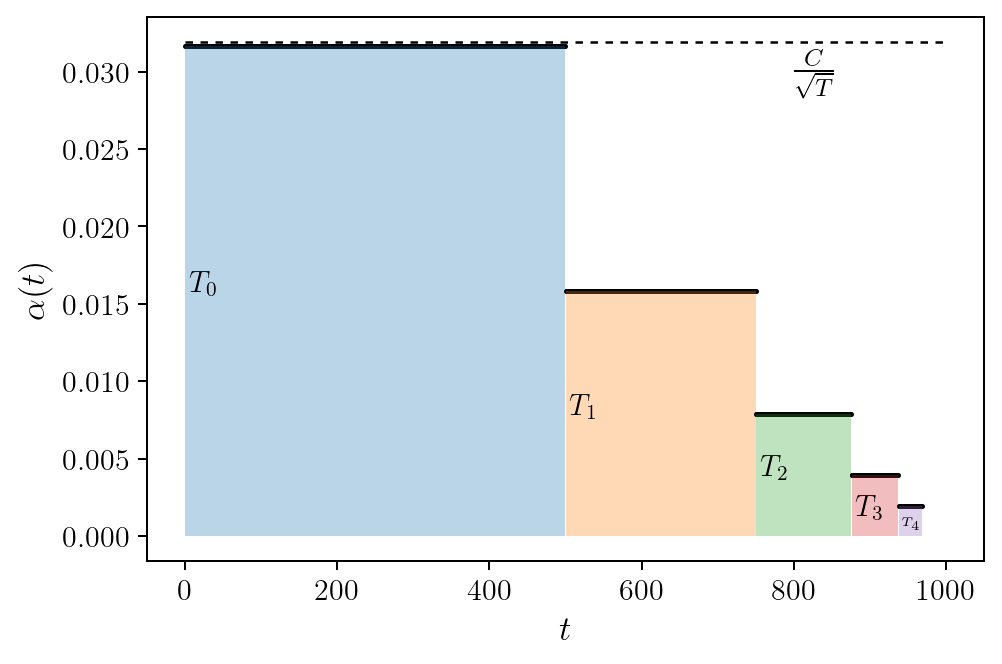

In [5]:
x = np.linspace(0, 1000, 1000)
plt.plot(x, (1.009 / np.sqrt(1000)) * np.ones(1000), color='black', ls='--', dashes=(3, 3), lw=1)
plt.xlabel("$t$")
plt.ylabel(r"$\alpha (t)$")
plt.text(800, 0.0295, r"$\frac{C}{\sqrt{T}}$", fontsize=14, color="black")

# add vlines for each of the T_i
for i in range(len(T_set[:5])):
    plt.scatter(x[int(T_set[i]):int(T_set[i+1])], step_sizes[int(T_set[i]):int(T_set[i+1])], color='black', s=1)
    plt.fill_between(x[int(T_set[i]):int(T_set[i+1])], step_sizes[int(T_set[i]):int(T_set[i+1])], alpha=0.3)
    
    # find area 
    y_range = step_sizes[int(T_set[i])]
    if i != 4 and i != 3:
        plt.text(T_set[i] + 5, y_range / 2, fr"$T_{i}$", fontsize=12, color="black")
    if i == 3:
        plt.text(T_set[i] + 5, y_range / 2 - 0.0006, fr"$T_{i}$", fontsize=12, color="black")
    if i == 4:
        plt.text(T_set[i] + 5, y_range / 2 - 0.0003, fr"$T_{i}$", fontsize=5, color="black")
    
plt.savefig('alpha.png', dpi=450)

# Experiments to Couple Analysis

Let us analyze a stochastic utility problem, a stochastic max-flow problem, and simple SVM under stochastic gradient descent.

# SVM

We have data $x_1,\dots,x_m\in\mathbb{R}^n$ coupled with binary outputs $y_1,\dots,y_m\in\{-1,1\}$, and would like to find the hyperplane that best separates the positive from the negative labels. There are way too many equivalent formulations of SGD between its primal form, dual form, and reparametrized nonsense. In the case of soft-margin SVMs, we can express the primal problem in Lagrangian form as

$$\min\limits_{w\in\mathbb{R}^n,b\in\mathbb{R}} \left\{w^Tw - \sum\limits_{i=1}^m \lambda_i y_i(w^Tx_i + b) + \sum\limits_{i=1}^m \lambda_i(1-\epsilon_i)\right\}$$

where $\epsilon>0$ is a proxy for how many errors in the classification we are fine dealing with, $b_i$ is the intercept term, and $\lambda_i$ is from the Lagrangian. Instead, let us rewrite the objective using the hinge-loss to obtain

$$\min\limits_{w\in\mathbb{R}^n,b\in\mathbb{R}}\left\{w^Tw + C\sum\limits_{i=1}^m \max\{0, 1-\epsilon_i - y_i(w^Tx_i - b)\}\right\}$$

for a hyperparameter $C$ to be tuned through CV and let us call the objective $L$. The partial **subderivatives** of this objective for a particular sample with respect to $w$ and $b$ are given by

$$\frac{\partial L_i}{\partial w}=\begin{cases} 2w - Cy_ix_i  & 1- \epsilon_i > y_i(w^Tx_i - b) \\ 2w & \text{Otherwise}\end{cases},$$

$$\frac{\partial L_i}{\partial b}=\begin{cases} Cy_i & 1- \epsilon_i > y_i(w^Tx_i - b) \\ 0 & \text{Otherwise}.\end{cases}$$

Then our update for each sample $(x_y,y_i,\epsilon_i)$ in SGD is given by 

$$\begin{bmatrix} w_{t+1} \\ b_{t+1}\end{bmatrix}\leftarrow \begin{bmatrix} w_t \\ b_t \end{bmatrix} - \eta_t \begin{bmatrix} \frac{\partial L_i}{\partial w_t} \\ \frac{\partial L_i}{b_t}\end{bmatrix} =\begin{cases} \begin{bmatrix} w_t-\eta_t(2w_t - Cy_ix_i) \\ b_t - \eta_tCy_i \end{bmatrix} & 1- \epsilon_i > y_i(w^T_tx_i - b_t) \\ \\ \begin{bmatrix} w_t(1-2\eta_t) \\ b_t\end{bmatrix} & \text{Otherwise}.\end{cases}$$

In Jain's paper, he considers the following simplifications to the problem: $C=\frac{1}{n}$ along with centered random variables implying that $b=0$.

Then the rest of the pseudo-code for SGD consists of computing the loss of the hinge loss of SVM for each training point - where I sample from the batches instead of computing the subgradient in entirety.

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_49325/895296656.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


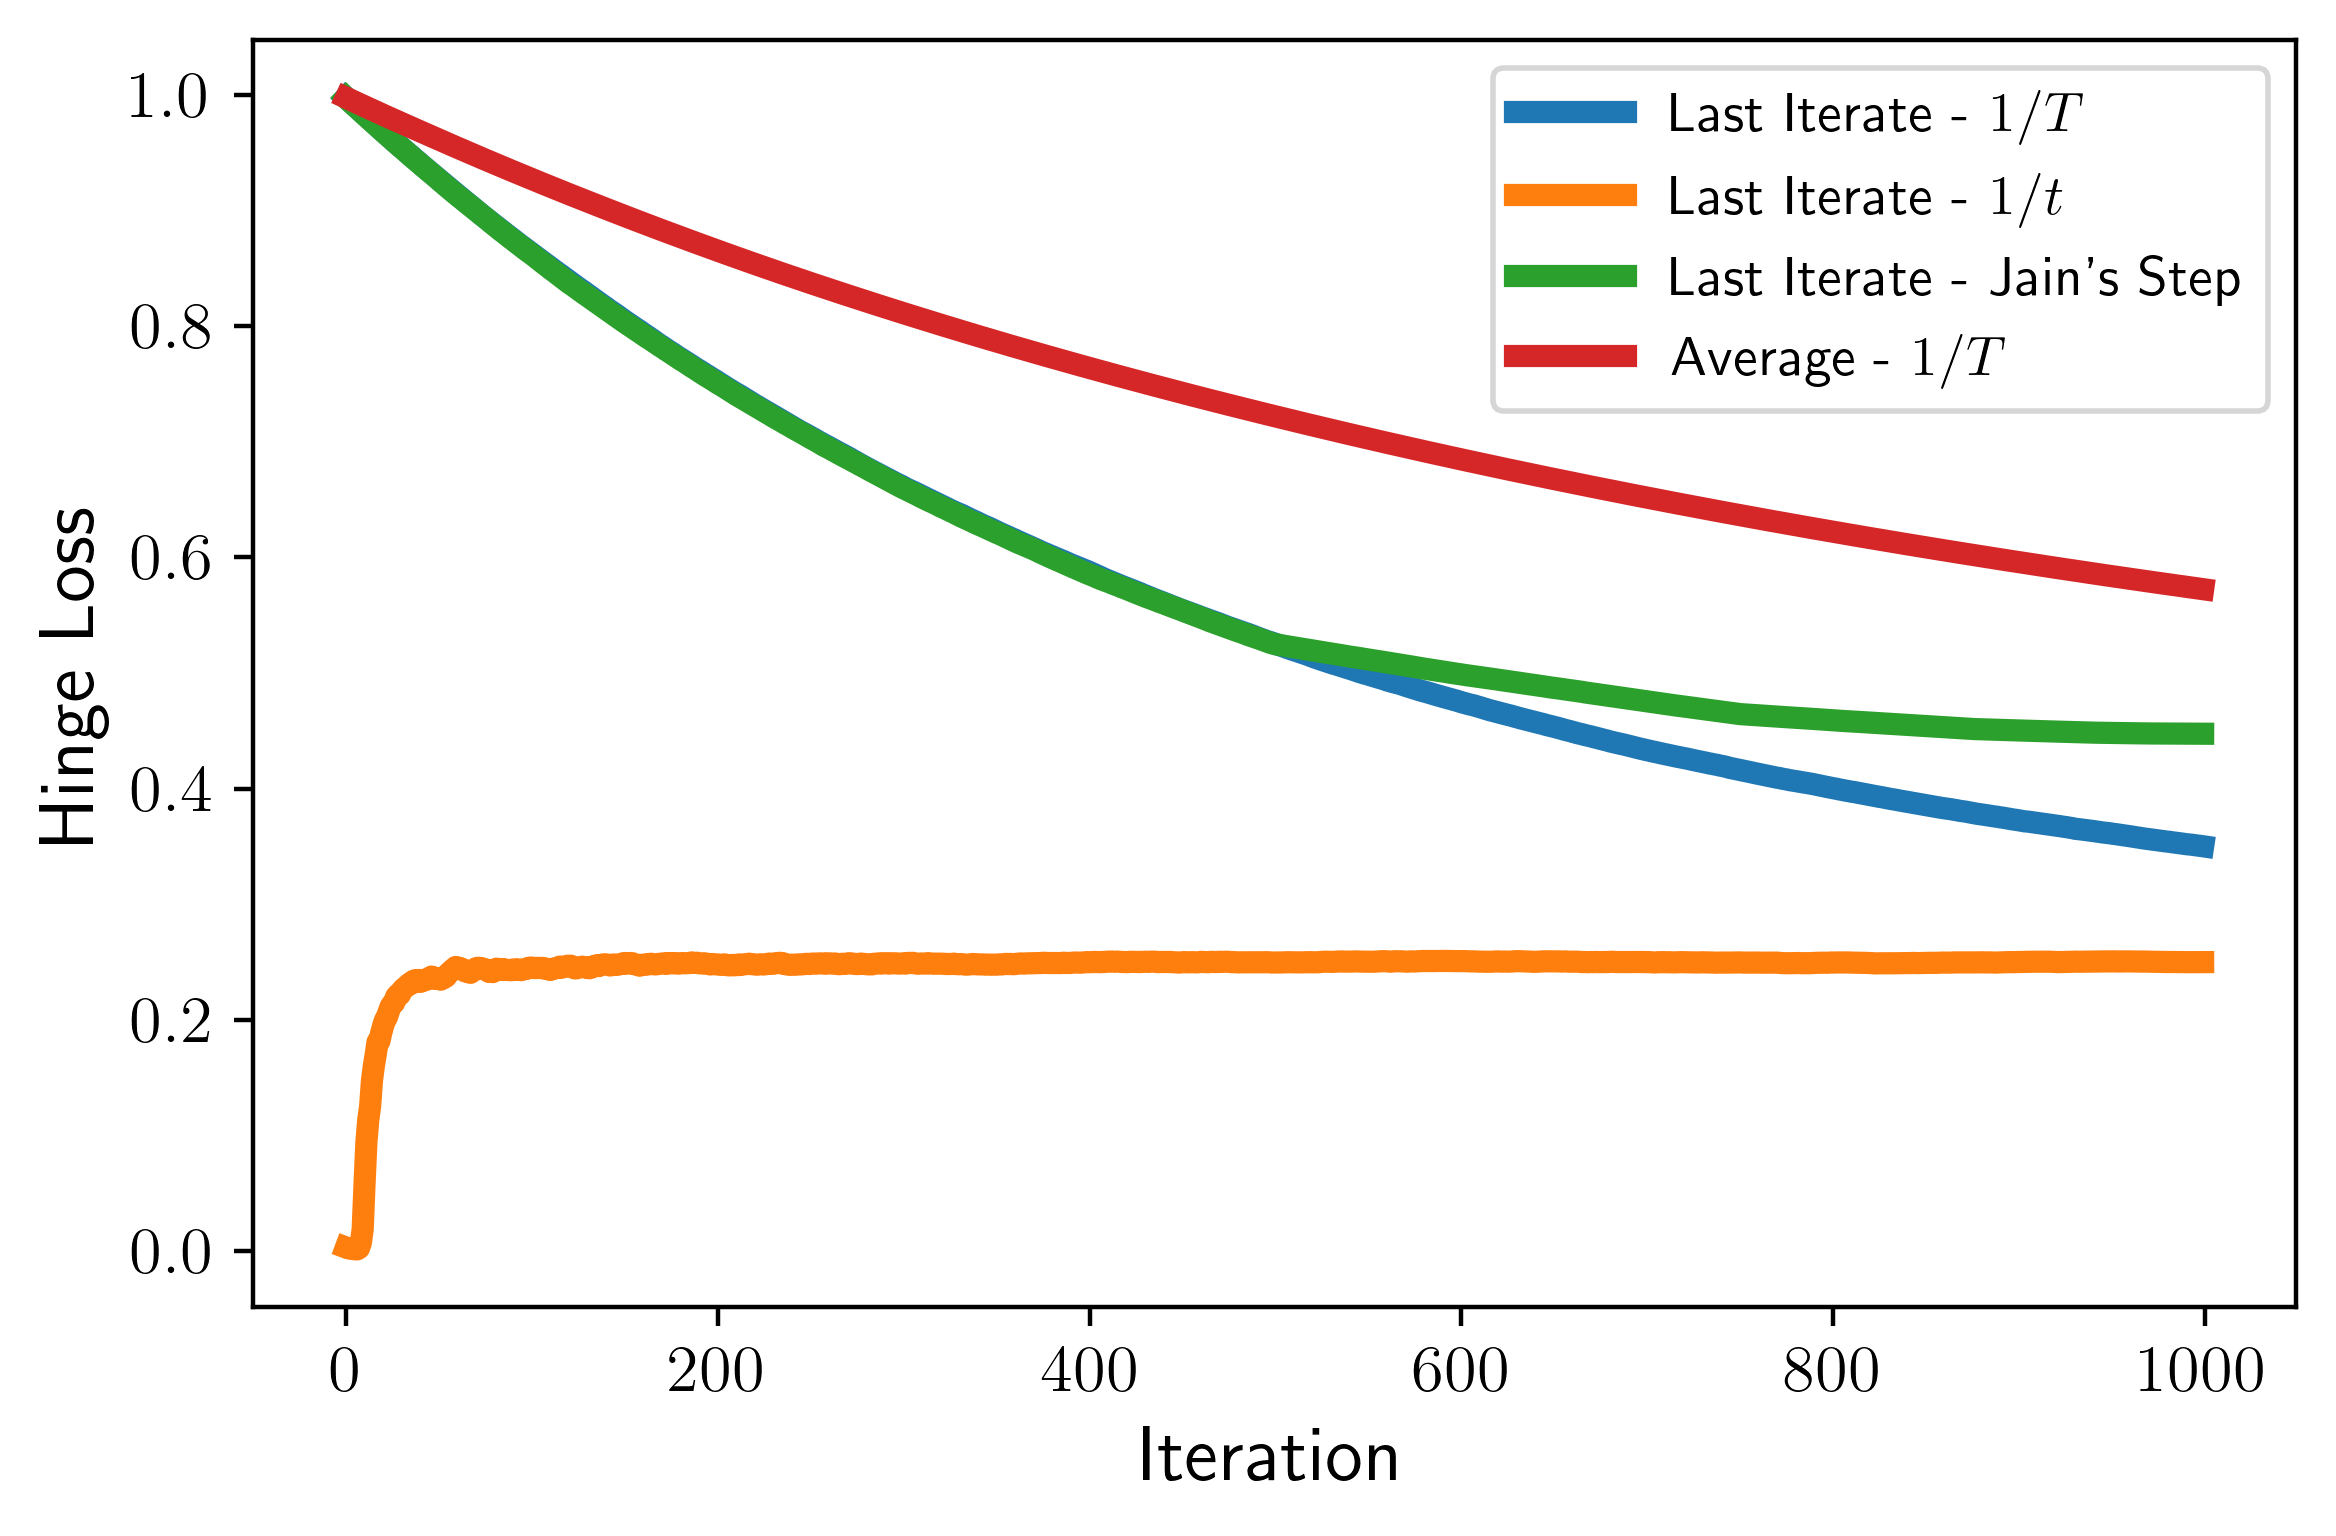

In [3]:
"""THOUGHTS:

Experiments should include the following step sizes:
- final iterate of Jains' step size
- final iterate of constant decay and step
- final iterate of geometrically decaying step size (not polynomial decay)
- average with constant step size
- suffix average (*time permitting - how to choose alpha though)

"""

# svm subgradient
def svm_subgrad(x, y, epsilon, w, b, C):
    # returns the svm subgrad in hinge loss (soft-margin)
    if 1 - epsilon > y*np.dot(x.T, w):
        return np.array([2*w - C*y*x, C*y], dtype=object)
    else:
        return np.array([C*y, 0], dtype=object).T
    
def svm_loss(X, Y, EPSILON, w, b, C):
    # capitalized letters denote arrays of them
    return np.dot(w, w) + C * sum([max([0, 1 - EPSILON[i] - Y[i] * (np.dot(w, X[:, i]) - b)]) for i in range(num_samples)])


X_dim = 30
num_samples = 500
X = np.random.normal(loc=5, size=(X_dim, num_samples))
Y = np.sign(X[1,:] + np.random.normal(loc=2, size=num_samples)) 
T = 1000 
b_0 = 0
w_0 = [np.zeros(X_dim), 0]
EPSILON = np.zeros(num_samples) + 1e-3 
C = 1 / num_samples 

# step sizes
def constant_step(t):
    return 1 / T

def constant_decay(t):
    return 1 / t

def sgd(T, EPSILON, step_size, average):
    # T is the number of iterations
    # EPSILON is a vector of size num_samples; acc threshold
    # step_size is a string argument
    # average is a boolean

    if step_size == "constant":
        steps = [constant_step(t) for t in range(T)]
    if step_size == "constant_decay":
        steps = [constant_decay(t) for t in range(1, T+1)]
    if step_size == "jain_step":
        T_set, alphas = jain_strong_stepsize(T, 1, 1)
        steps = alphas

    losses = []
    w_t = w_0
    w = []
    for t in range(T):
        sample = np.random.randint(num_samples)
        g = svm_subgrad(X[:, sample], Y[sample], EPSILON[sample], w_t[0], 0, C)
        w_t = w_t - steps[t] * g
        if average:
            w.append(w_t)
            losses.append(svm_loss(X, Y, EPSILON, np.mean(np.array(w, dtype=object)[:, 0]), 0, C))
        else:
            losses.append(svm_loss(X, Y, EPSILON, w_t[0], 0, C))

    return losses

# fetch results
constant_losses = sgd(1000, EPSILON, "constant", False)
constant_decay_losses = sgd(1000, EPSILON, "constant_decay", False)
jain_losses = sgd(1000, EPSILON, "jain_step", False)
average_losses = sgd(1000, EPSILON, "constant", True)

# visualize the results - same experiment as Jain
plt.plot(np.arange(T), constant_losses, label=r"Last Iterate - $1/T$")
plt.plot(np.arange(T), constant_decay_losses, label=r"Last Iterate - $1/t$")
plt.plot(np.arange(T), jain_losses, label=r"Last Iterate - Jain's Step")
plt.plot(np.arange(T), average_losses, label=r"Average - $1/T$")
plt.xlabel(r"Iteration")
plt.ylabel(r"Hinge Loss")
plt.legend(prop={'size': 10})
plt.tight_layout()
plt.show()

# Subexperiment: Varying T, Epsilon, Sigma 

Jain only considered running the experiment many times over with the same parameters. This really is no robustness check and instead, he should change the parameters $T$, $\epsilon$, and $\sigma^2$ to garner a better sense of which method actually prevails. For varying $T$, we simply plot the different $T$ and experiments over each other. For varying $\epsilon$, we plot the variances of the estimates. For varying $\sigma^2$, 

## Varying Epsilon

In [4]:
constant_runs = []
constant_decay_runs = []
jain_runs = []
average_runs = []
for epsilon in np.linspace(1e-7, 0.1, 10):
    EPSILON = epsilon + np.zeros(num_samples)
    # run each trial
    constant_losses = sgd(T, EPSILON, "constant", False)
    constant_decay_losses = sgd(T, EPSILON, "constant_decay", False)
    jain_losses = sgd(T, EPSILON, "jain_step", False)
    average_losses = sgd(T, EPSILON, "constant", True)
    
    # append to runs
    constant_runs.append(constant_losses)
    constant_decay_runs.append(constant_decay_losses)
    jain_runs.append(jain_losses)
    average_runs.append(average_losses)

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_49325/895296656.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


KeyboardInterrupt: 

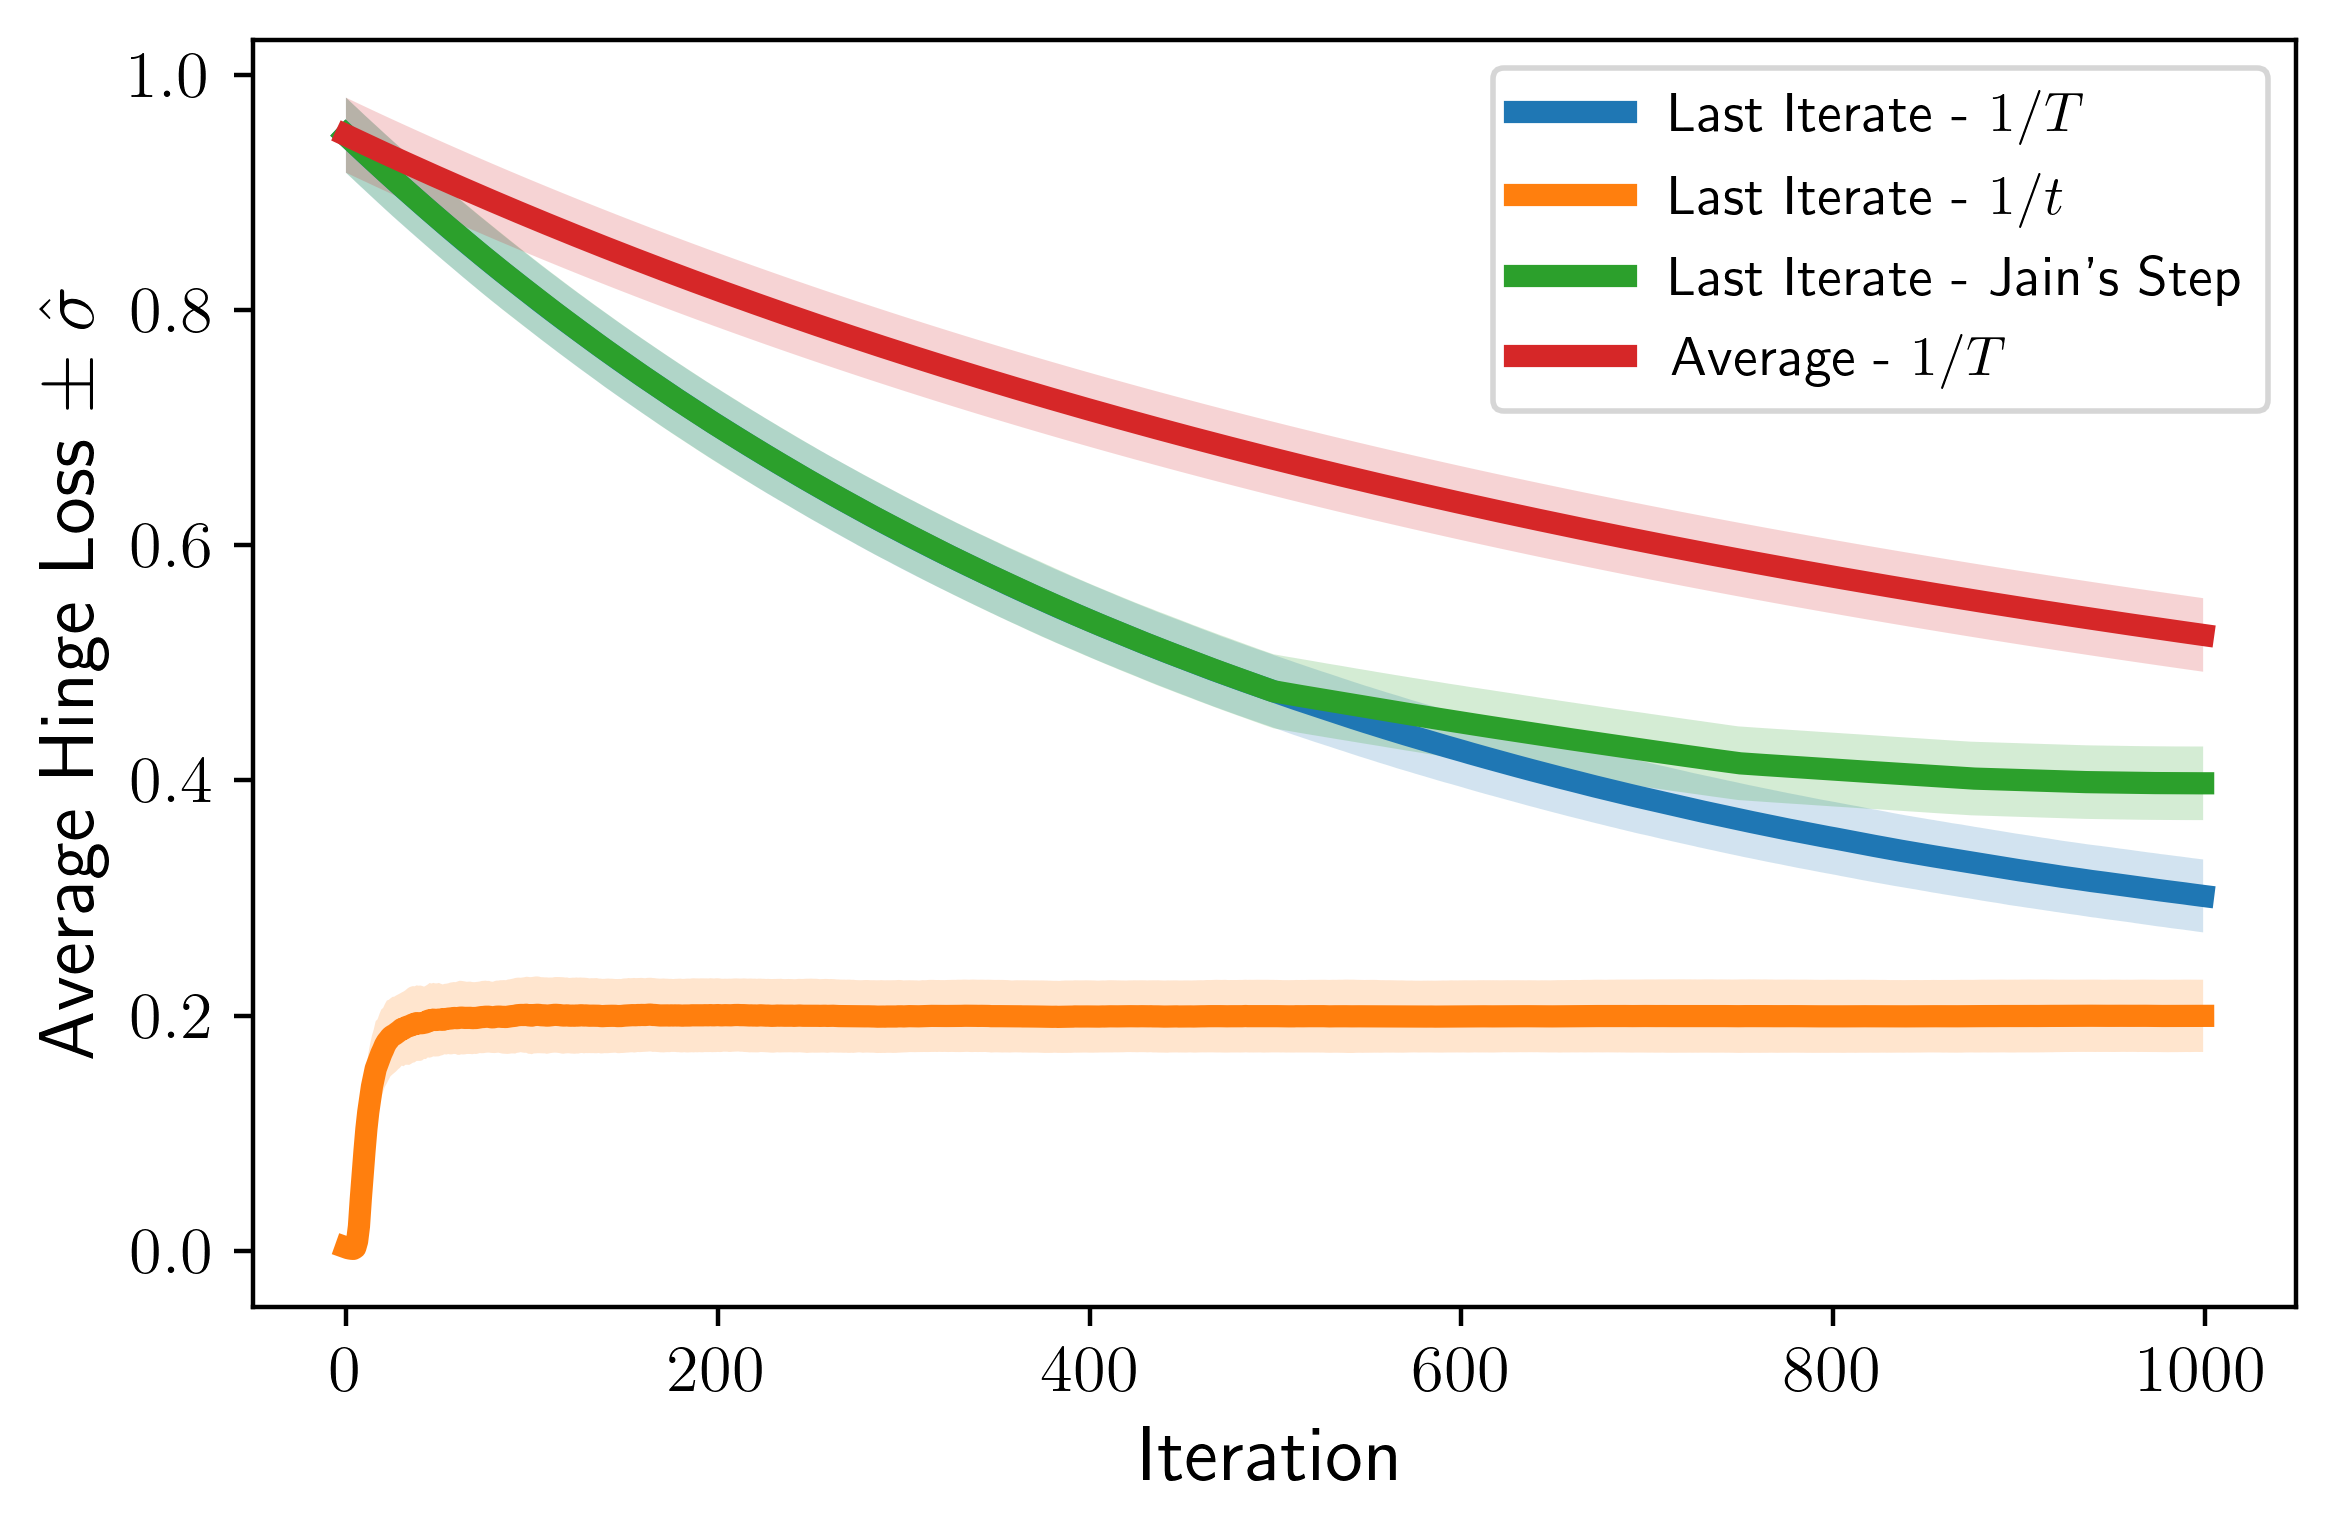

In [143]:
fig, ax = plt.subplots()
constant_std = np.sqrt(np.var(constant_runs, axis=0))
constant_decay_std = np.sqrt(np.var(constant_decay_runs, axis=0))
jain_std = np.sqrt(np.var(jain_runs, axis=0))
average_std = np.sqrt(np.var(average_runs, axis=0))

ax.plot(np.arange(len(constant_runs[0])), np.mean(constant_runs, axis=0), label=r"Last Iterate - $1/T$")
ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(constant_runs, axis=0) - constant_std), (np.mean(constant_runs, axis=0) + constant_std), alpha=0.2)

ax.plot(np.arange(len(constant_runs[0])), np.mean(constant_decay_runs, axis=0), label=r"Last Iterate - $1/t$")
ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(constant_decay_runs, axis=0) - constant_decay_std), (np.mean(constant_decay_runs, axis=0) + constant_decay_std), alpha=0.2)

ax.plot(np.arange(len(constant_runs[0])), np.mean(jain_runs, axis=0), label=r"Last Iterate - Jain's Step")
ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(jain_runs, axis=0) - jain_std), (np.mean(jain_runs, axis=0) + jain_std), alpha=0.2)

ax.plot(np.arange(len(constant_runs[0])), np.mean(average_runs, axis=0), label=r"Average - $1/T$")
ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(average_runs, axis=0) - average_std), (np.mean(average_runs, axis=0) + average_std), alpha=0.2)
plt.legend(prop={'size': 10})
plt.xlabel(r"Iteration")
plt.ylabel(r"Average Hinge Loss $\pm\;\hat{\sigma}$")
plt.tight_layout()
plt.savefig("avg_hinge.png", dpi=450)
plt.show()

## Varying T

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_40797/1298581193.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


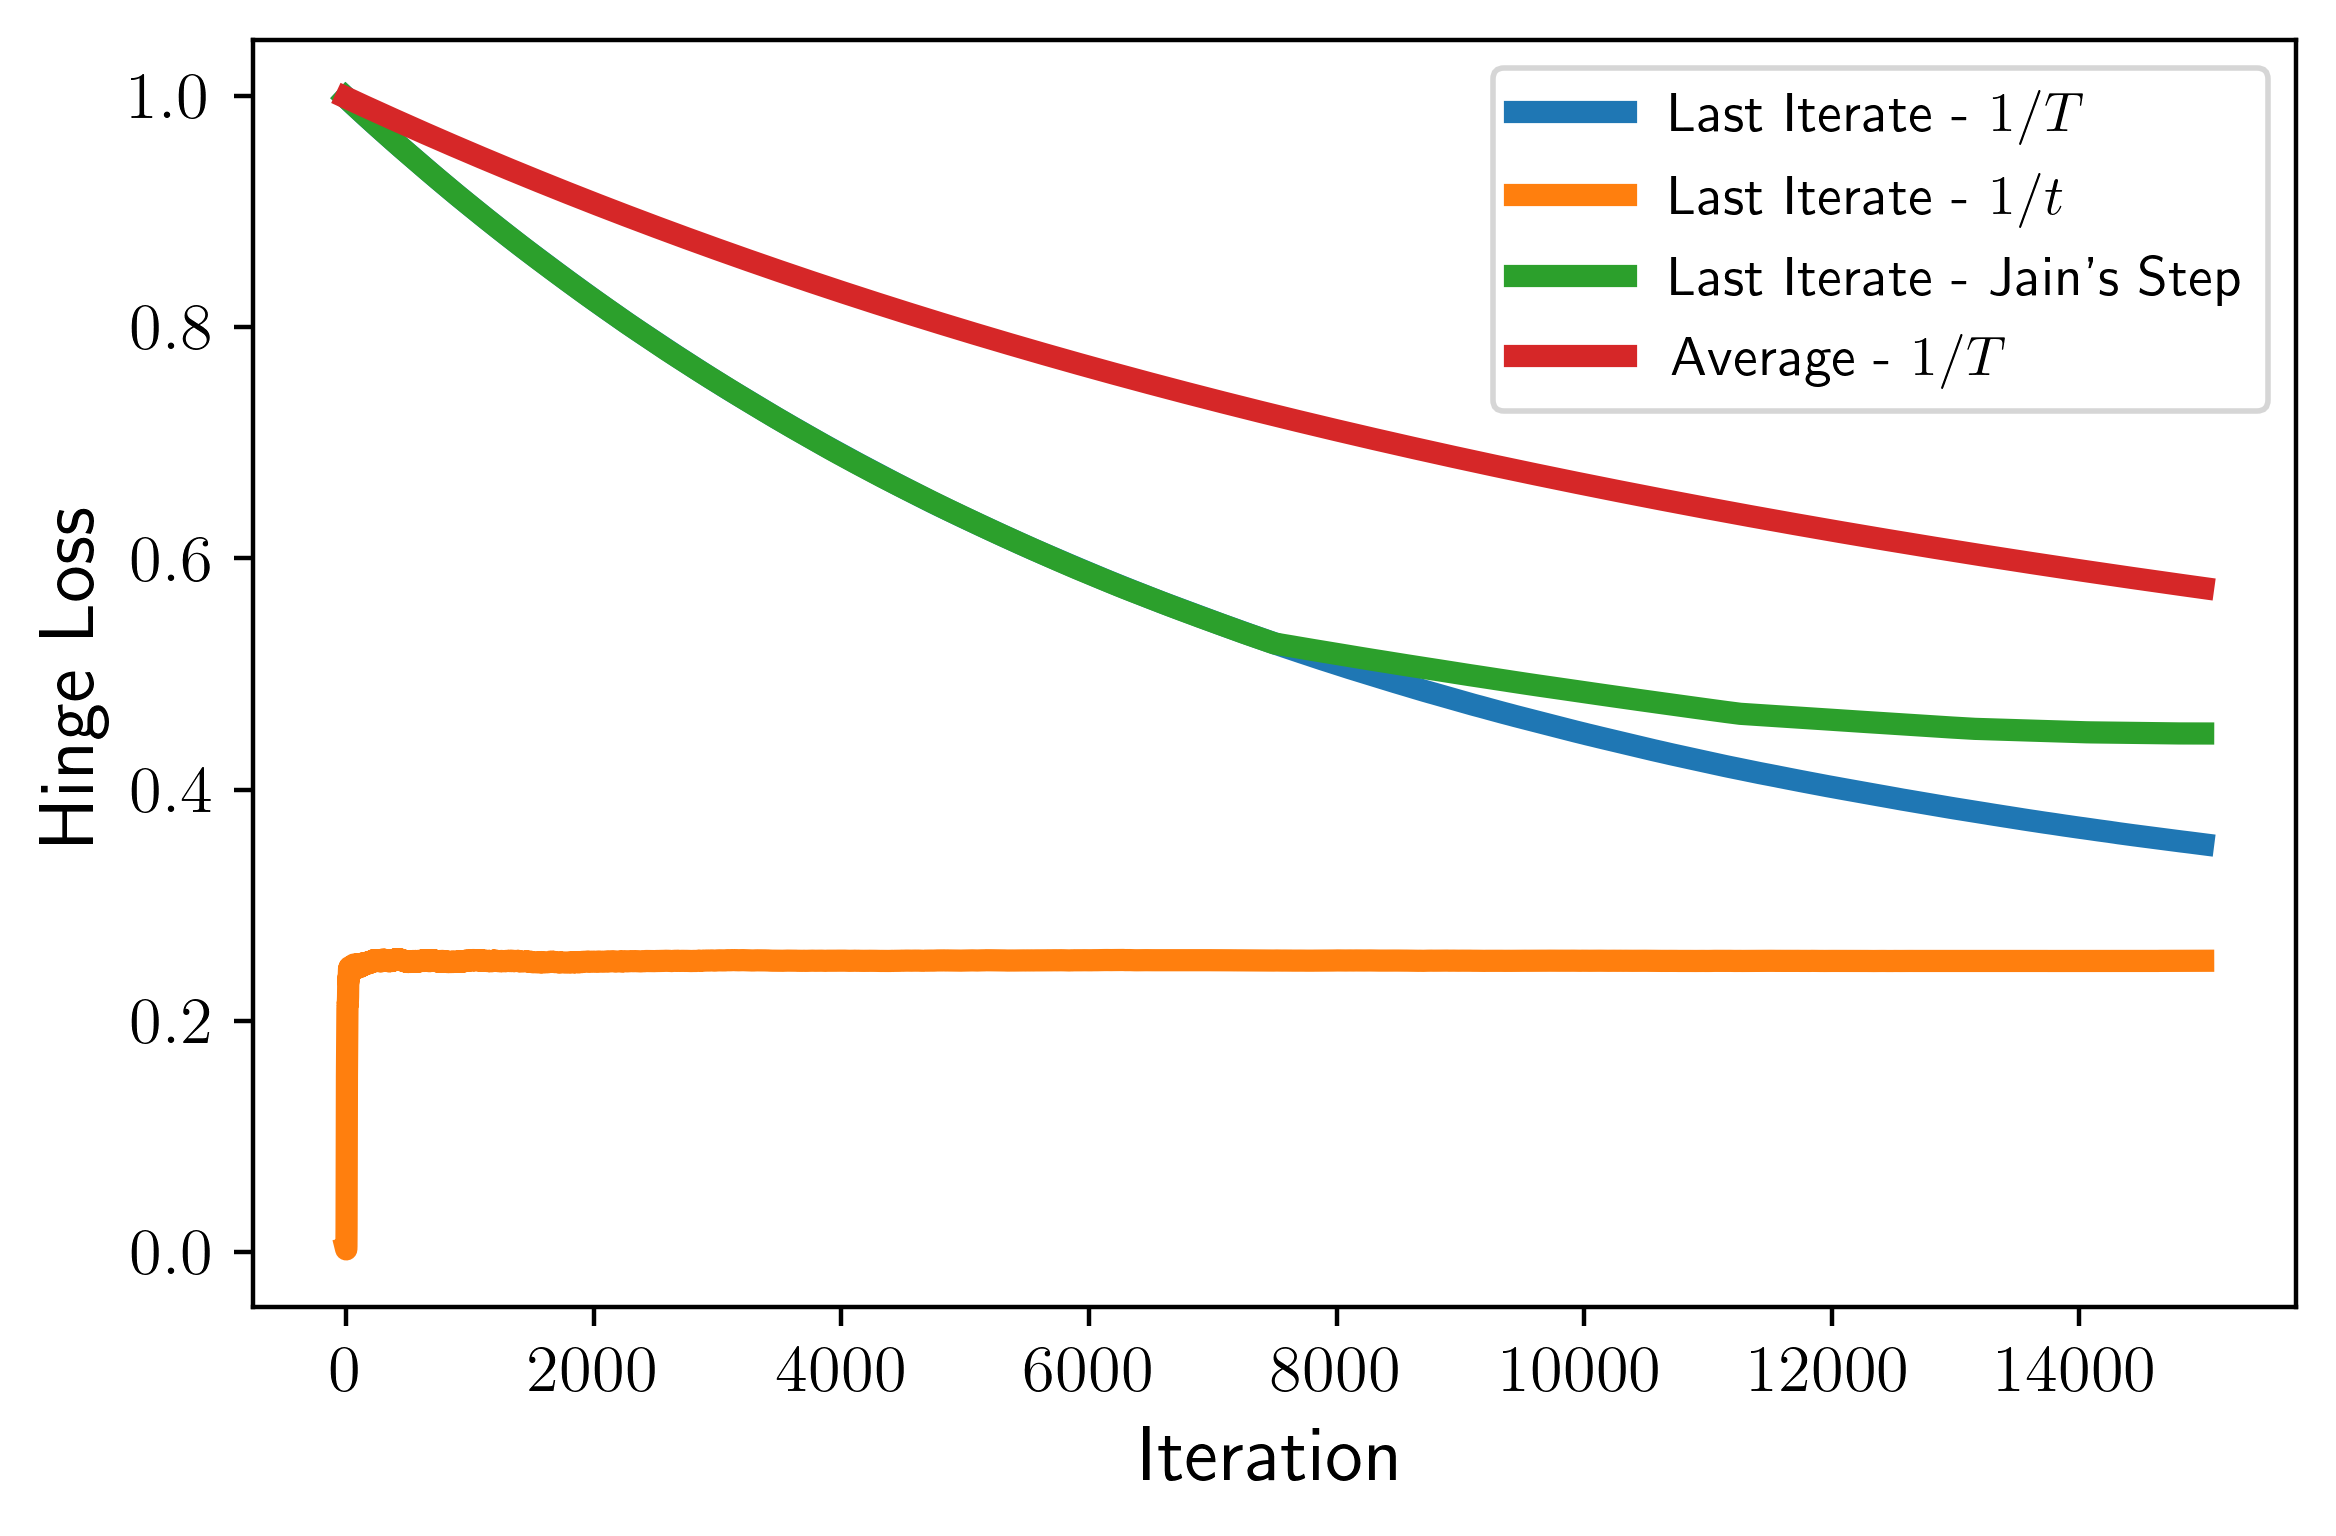

In [158]:
EPSILON = np.zeros(num_samples) + 1e-3
T = 15000
# run each trial
constant_losses = sgd(T, EPSILON, "constant", False)
constant_decay_losses = sgd(T, EPSILON, "constant_decay", False)
jain_losses = sgd(T, EPSILON, "jain_step", False)
average_losses = sgd(T, EPSILON, "constant", True)

# visualize the results - same experiment as Jain
plt.plot(np.arange(T), constant_losses, label=r"Last Iterate - $1/T$")
plt.plot(np.arange(T), constant_decay_losses, label=r"Last Iterate - $1/t$")
plt.plot(np.arange(T), jain_losses, label=r"Last Iterate - Jain's Step")
plt.plot(np.arange(T), average_losses, label=r"Average - $1/T$")
plt.xlabel(r"Iteration")
plt.ylabel(r"Hinge Loss")
plt.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig(f'hinge_loss_T{T}')
plt.show()

## Varying $\sigma^2$

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_40797/4029059275.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


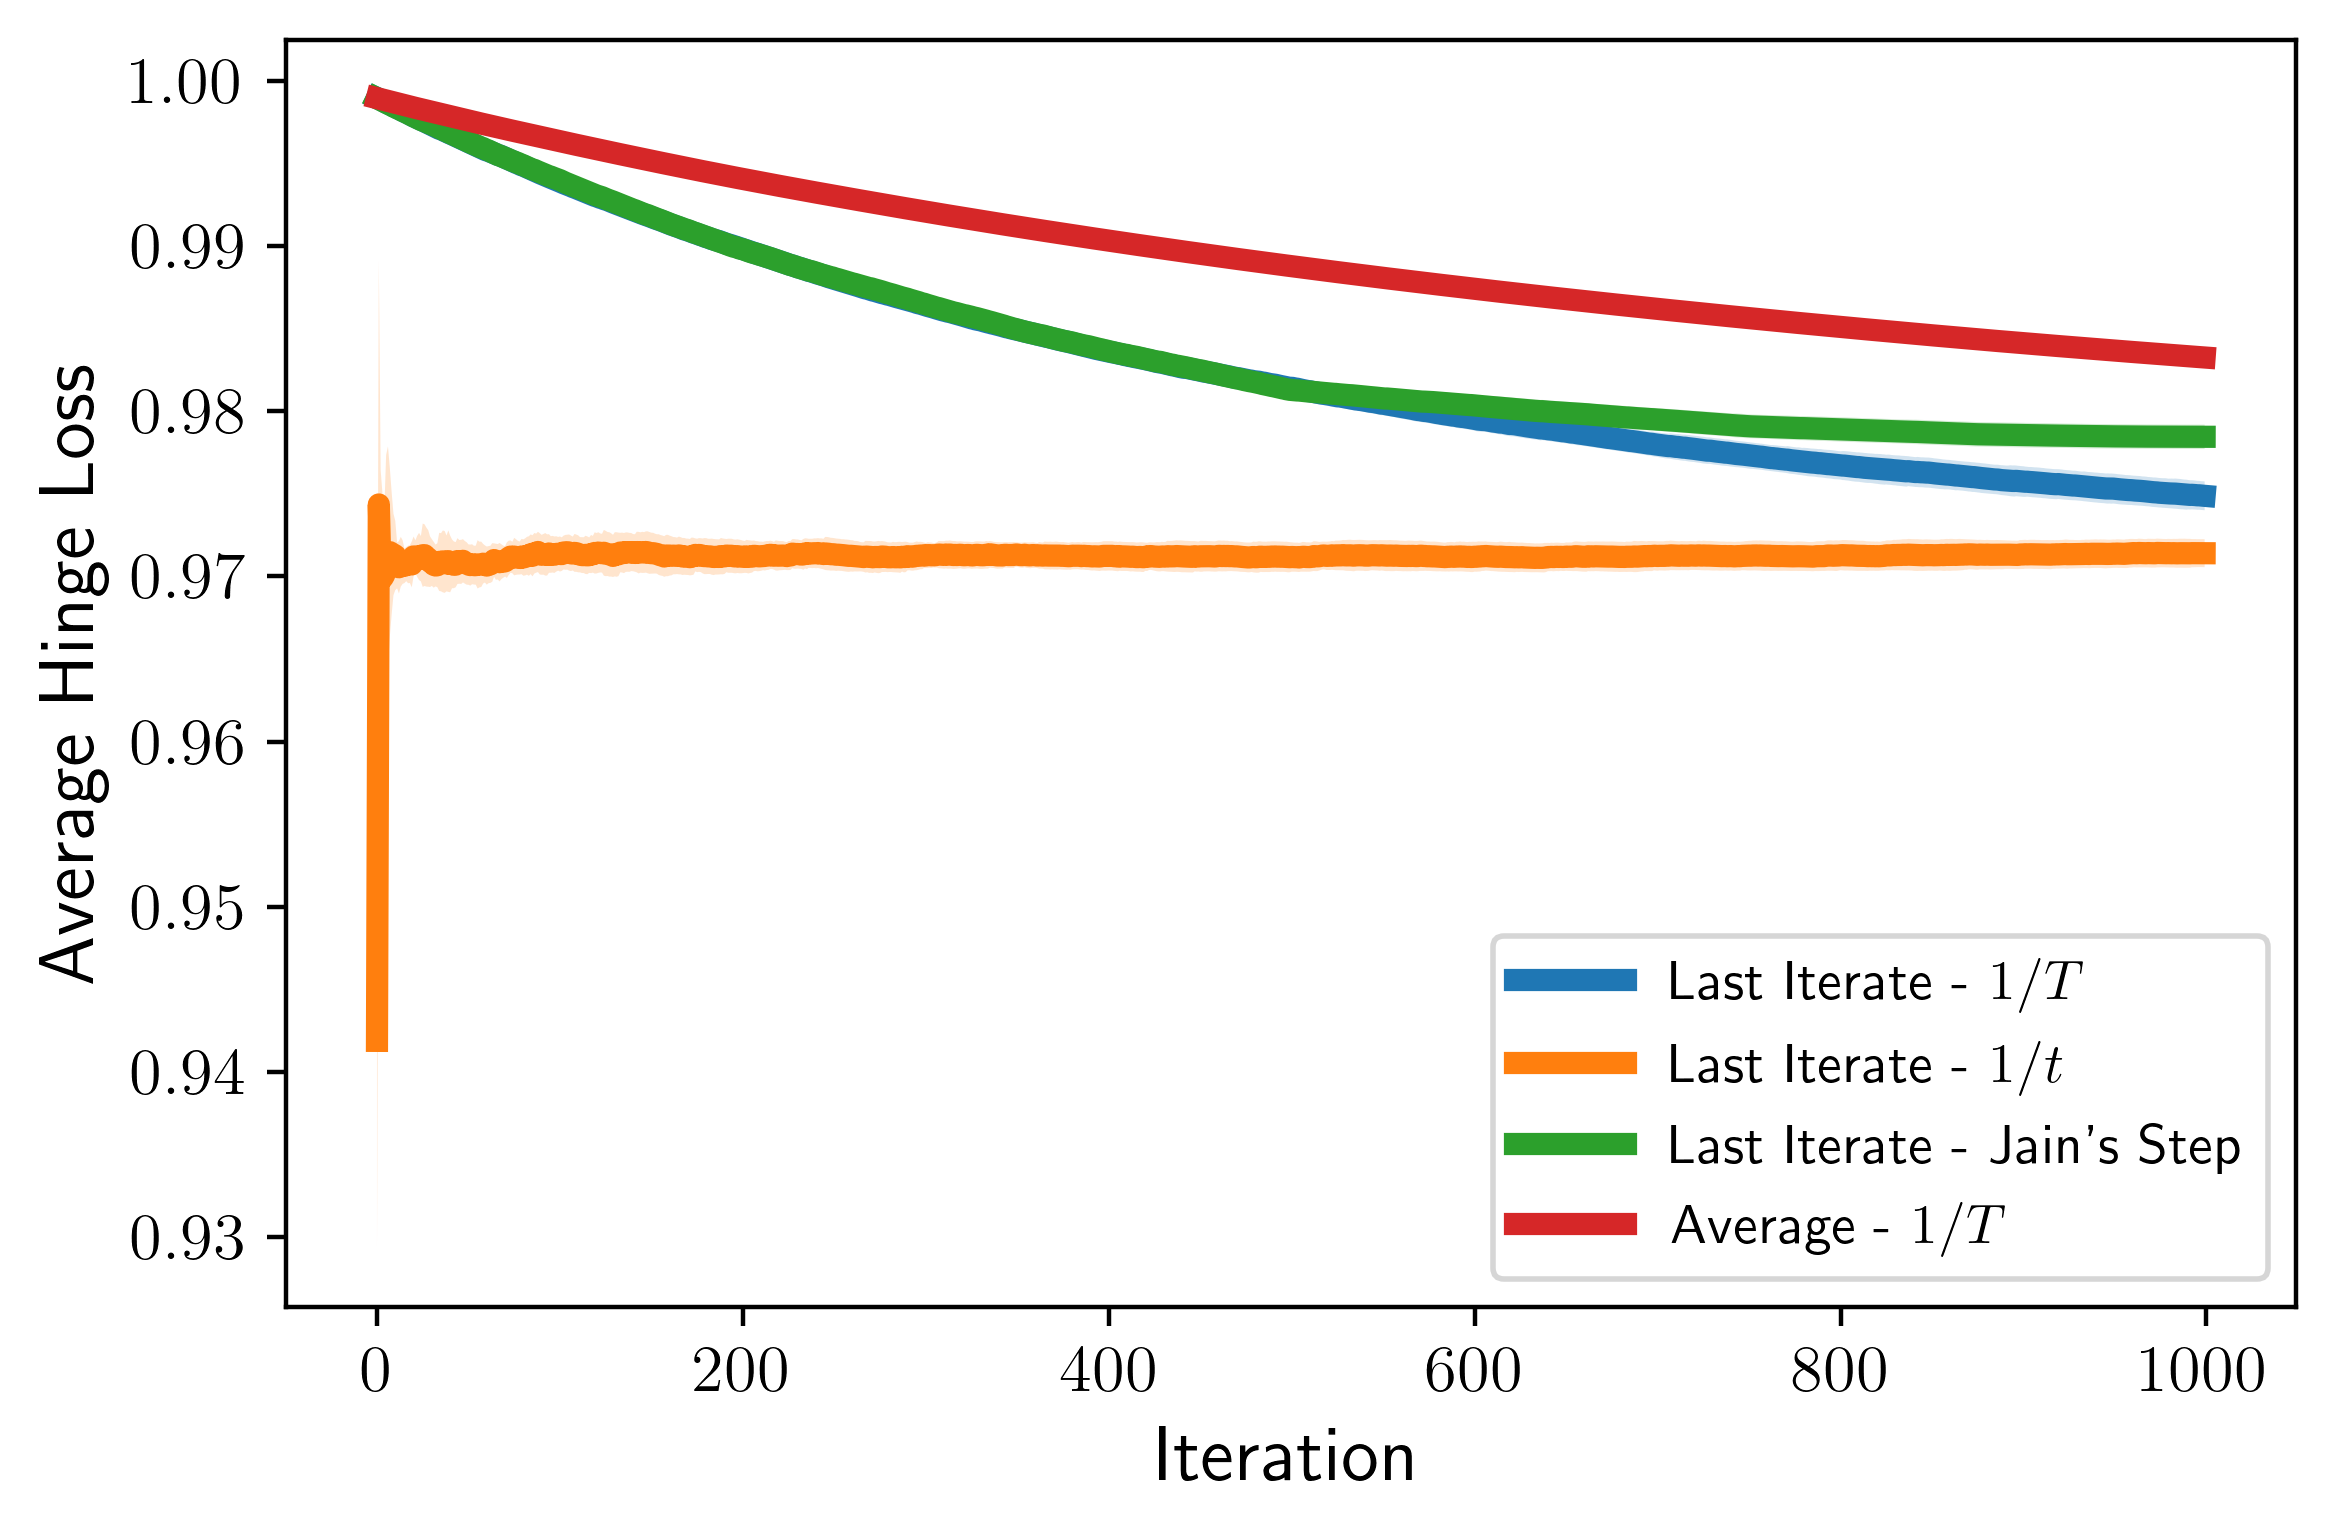

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_40797/4029059275.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


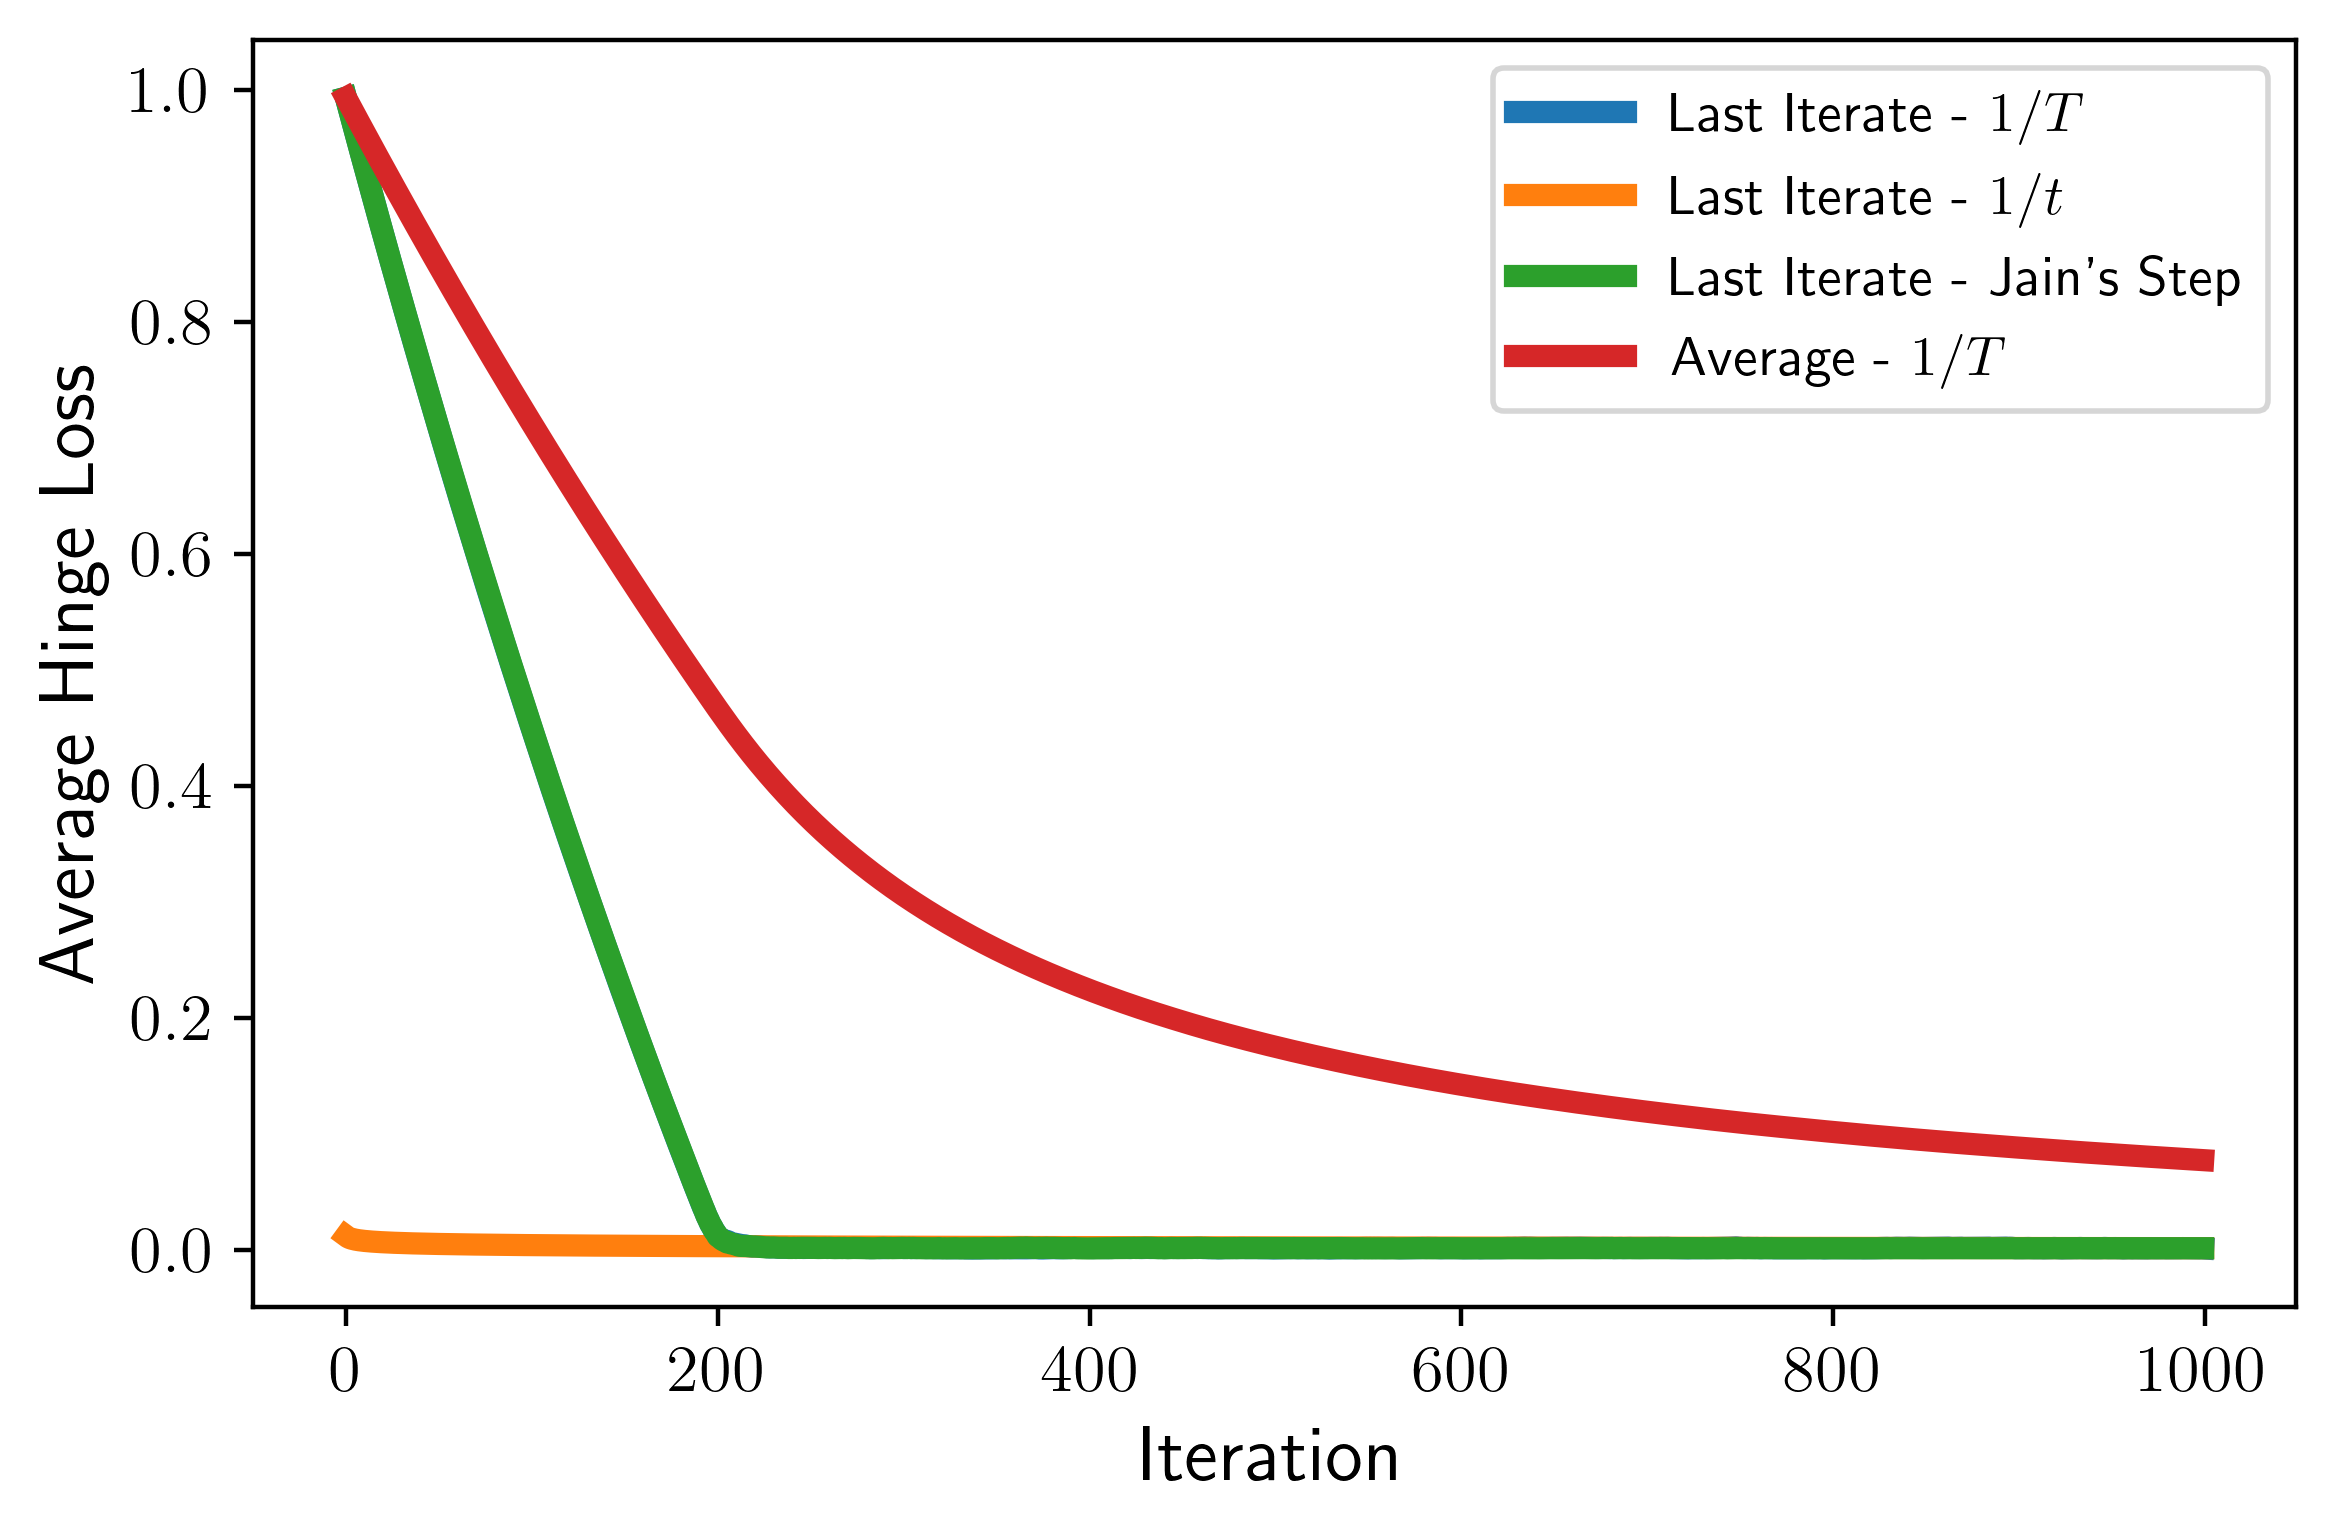

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_40797/4029059275.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


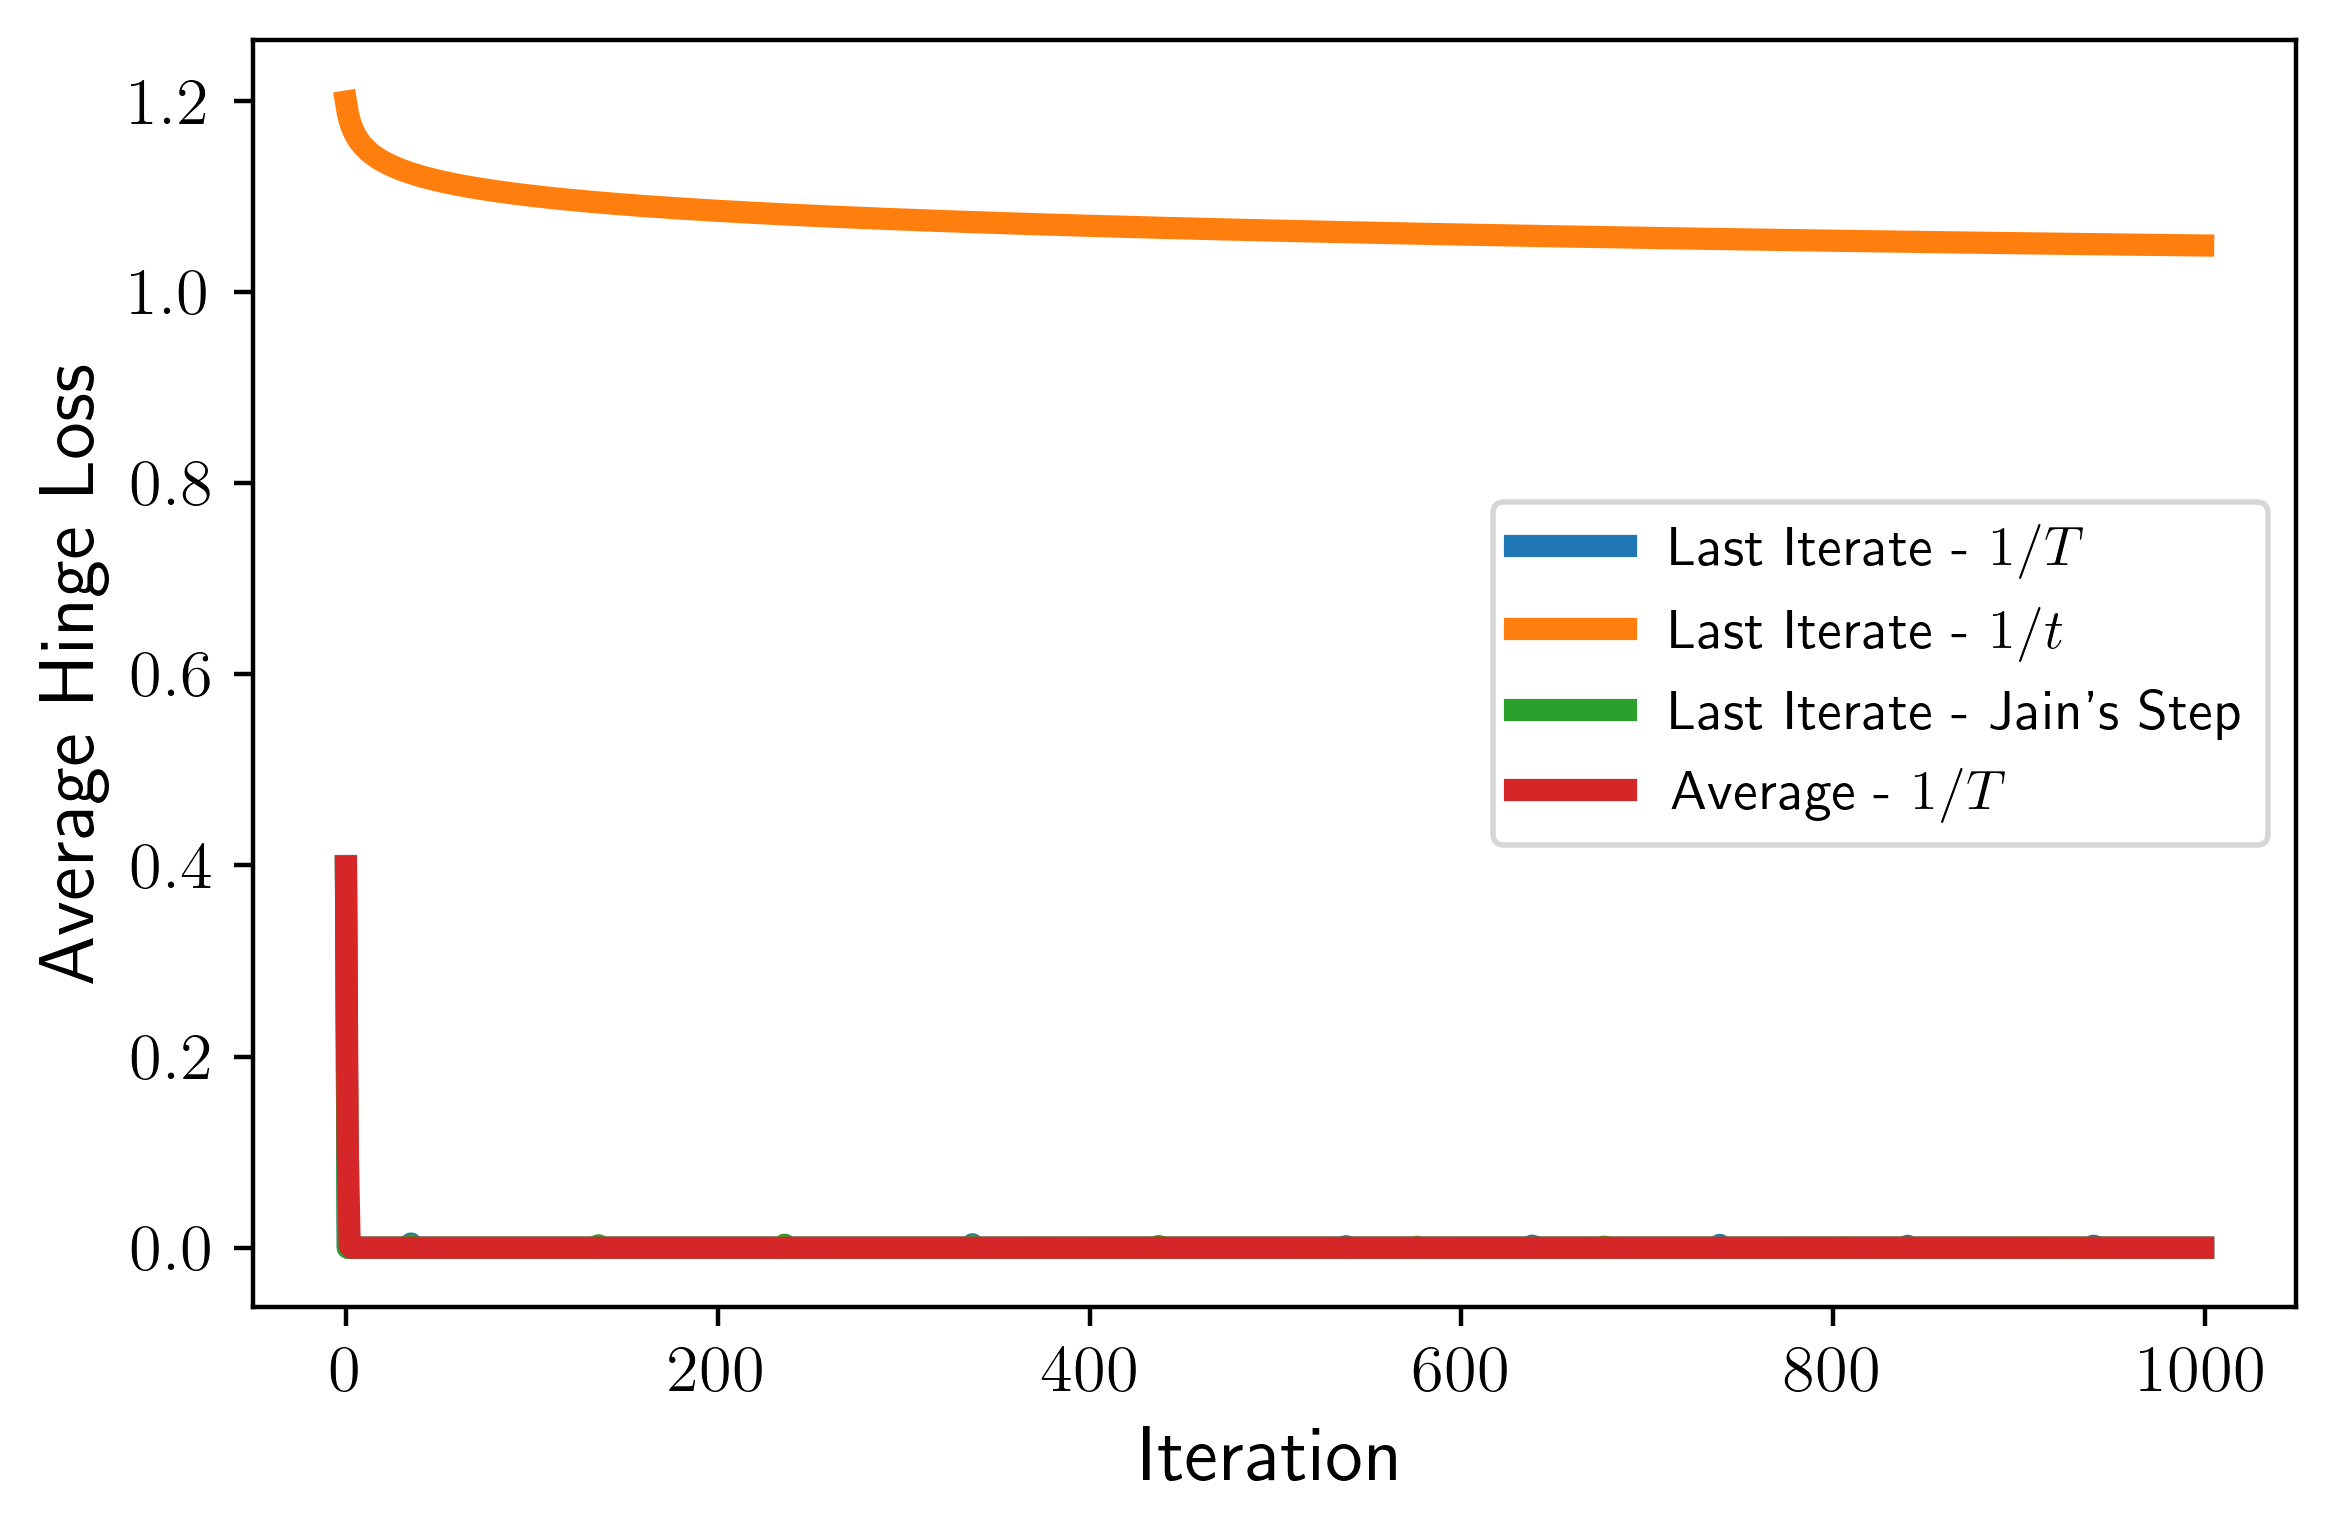

/var/folders/3d/7j0pnmj52_d00wg07vphgncr0000gn/T/ipykernel_40797/4029059275.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_t = w_t - steps[t] * g


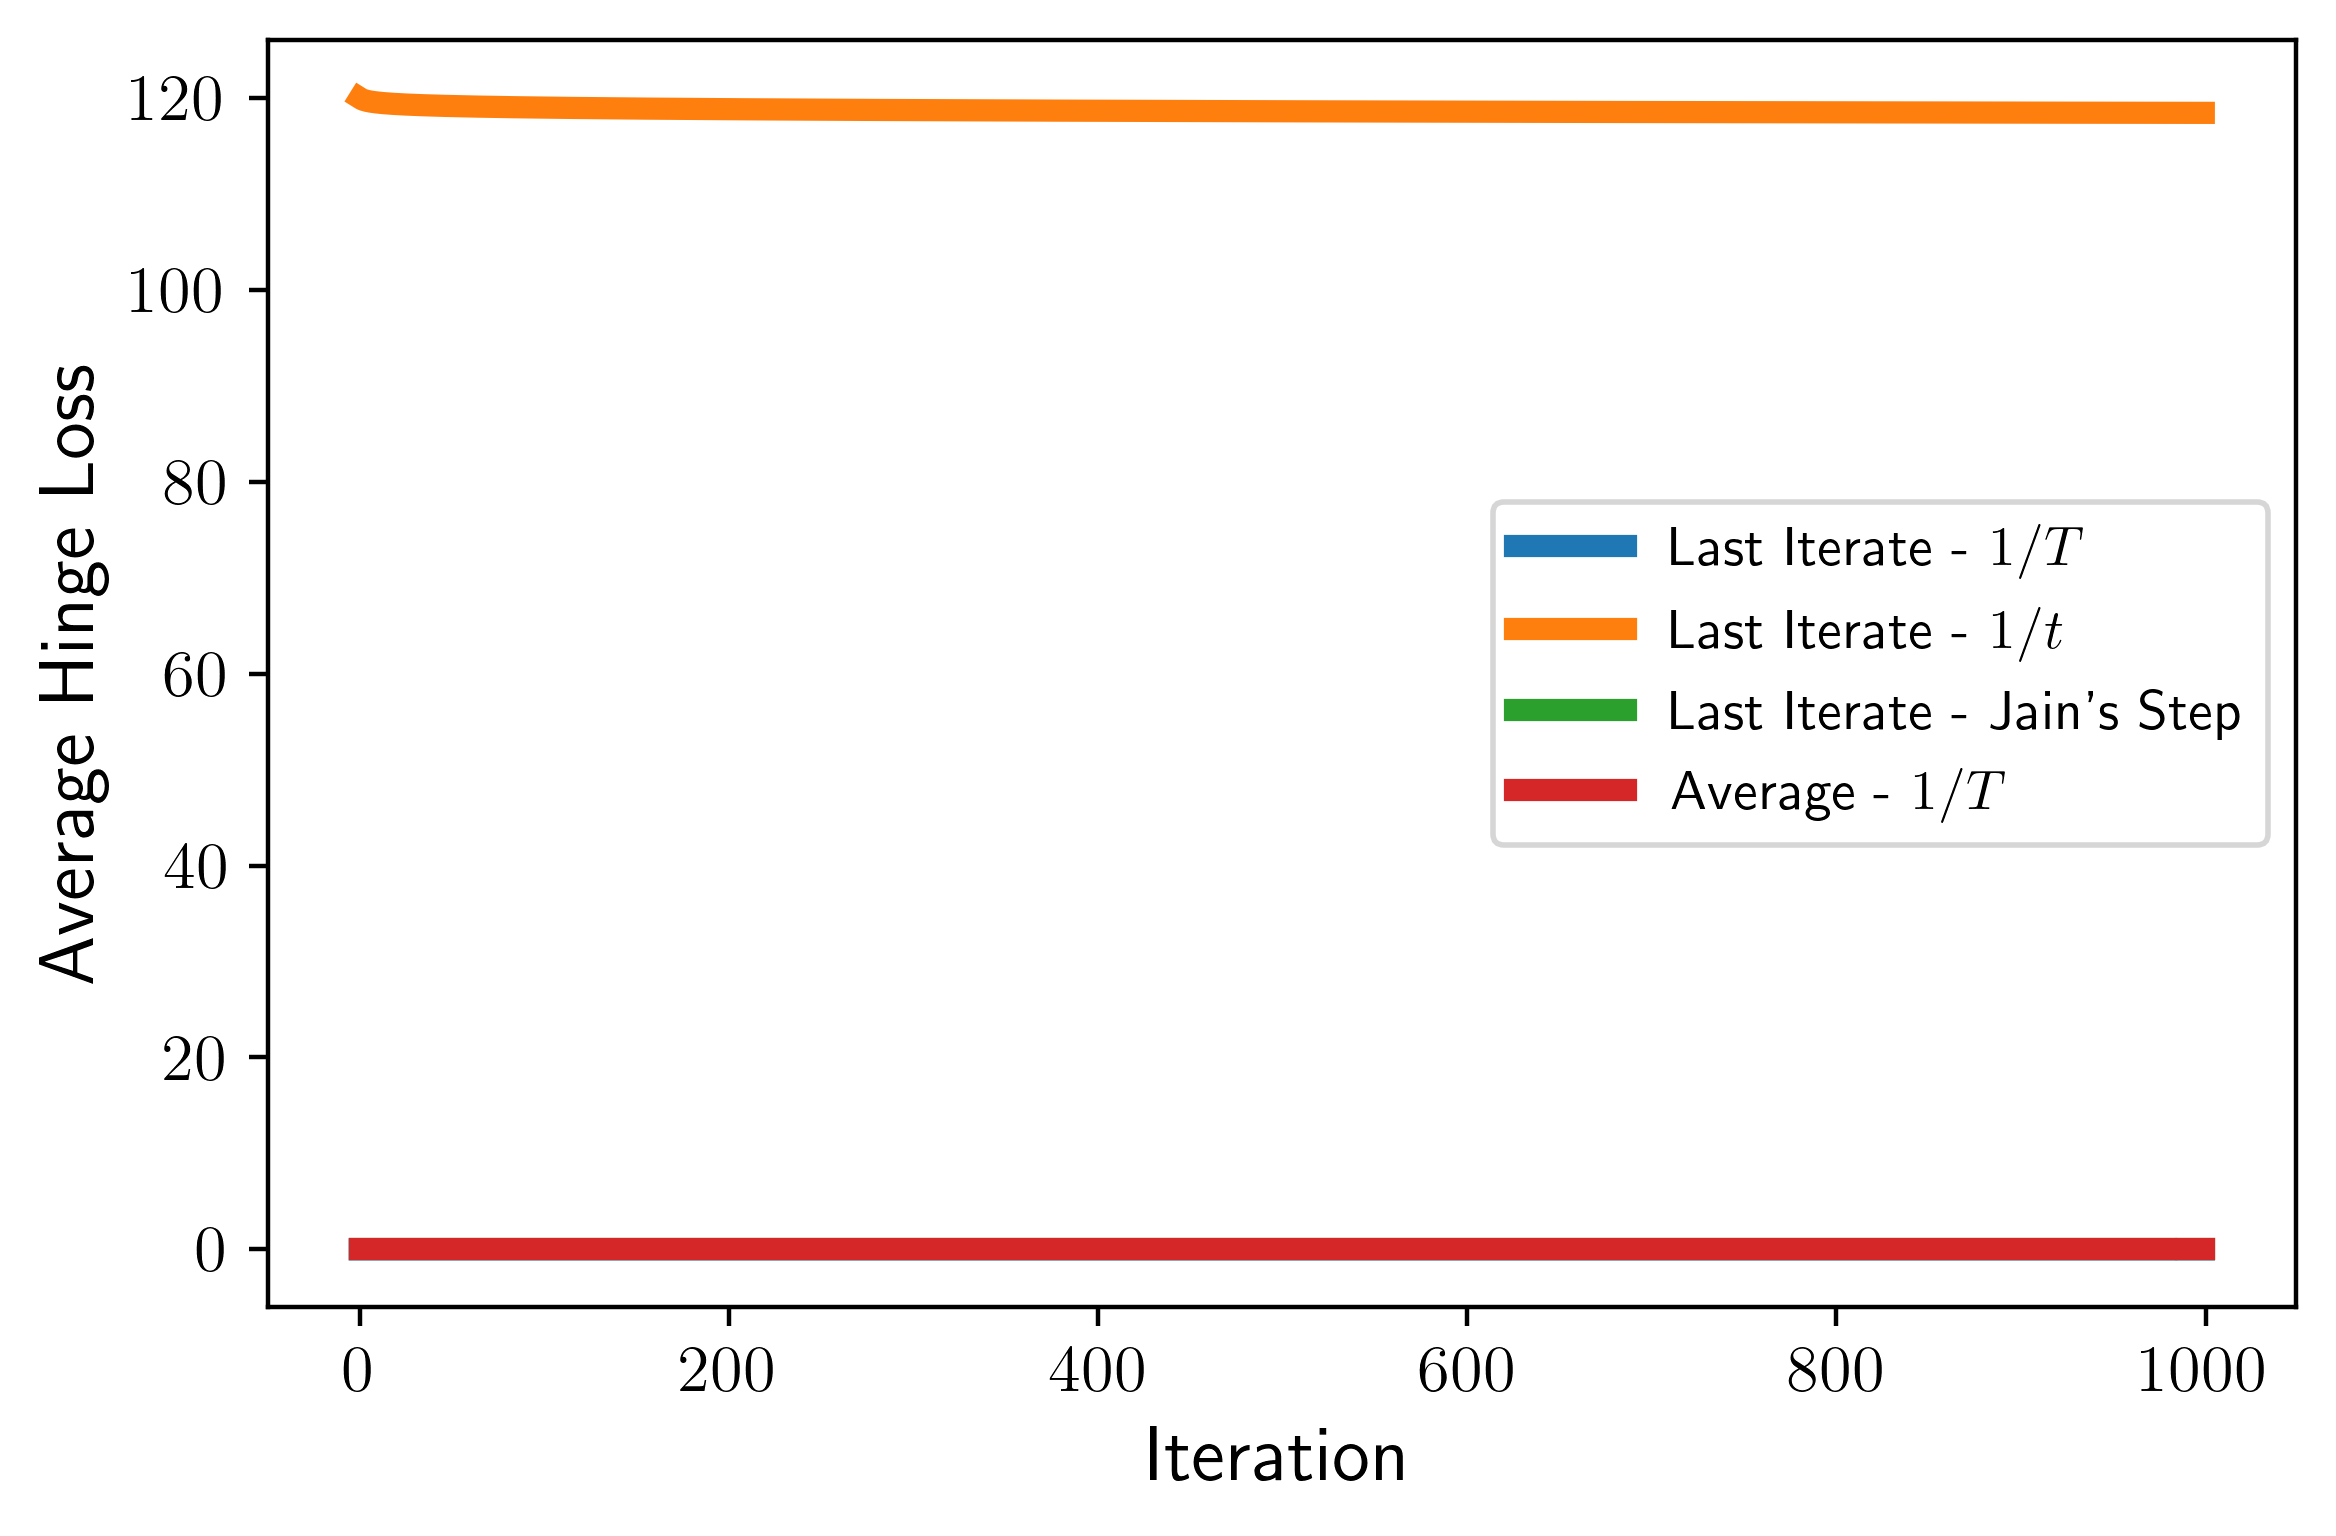

In [154]:
# for this one, I think I will look at a few different options of the variance and run some trials for each
for sigma in [1, 10, 100, 1000]: 
    constant_runs = []
    constant_decay_runs = []
    jain_runs = []
    average_runs = []
    for i in range(13):
        X_dim = 30
        num_samples = 500
        X = np.random.normal(loc=sigma, size=(X_dim, num_samples))
        Y = np.sign(X[1,:] + np.random.normal(loc=2, size=num_samples)) 
        T = 1000 # feels kind of arbitrary tbh - we will gridsearch this
        b_0 = 0
        w_0 = [np.zeros(X_dim), 0]
        EPSILON = np.zeros(num_samples) + 1e-3 # we will gridsearch this
        C = 1 / num_samples # supposedly use CV - idk 
        constant_losses = sgd(T, EPSILON, "constant", False)
        constant_decay_losses = sgd(T, EPSILON, "constant_decay", False)
        jain_losses = sgd(T, EPSILON, "jain_step", False)
        average_losses = sgd(T, EPSILON, "constant", True)
        
        # append to runs
        constant_runs.append(constant_losses)
        constant_decay_runs.append(constant_decay_losses)
        jain_runs.append(jain_losses)
        average_runs.append(average_losses)
        
    fig, ax = plt.subplots()
    constant_std = np.sqrt(np.var(constant_runs, axis=0))
    constant_decay_std = np.sqrt(np.var(constant_decay_runs, axis=0))
    jain_std = np.sqrt(np.var(jain_runs, axis=0))
    average_std = np.sqrt(np.var(average_runs, axis=0))

    ax.plot(np.arange(len(constant_runs[0])), np.mean(constant_runs, axis=0), label=r"Last Iterate - $1/T$")
    ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(constant_runs, axis=0) - constant_std), (np.mean(constant_runs, axis=0) + constant_std), alpha=0.2)

    ax.plot(np.arange(len(constant_runs[0])), np.mean(constant_decay_runs, axis=0), label=r"Last Iterate - $1/t$")
    ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(constant_decay_runs, axis=0) - constant_decay_std), (np.mean(constant_decay_runs, axis=0) + constant_decay_std), alpha=0.2)

    ax.plot(np.arange(len(constant_runs[0])), np.mean(jain_runs, axis=0), label=r"Last Iterate - Jain's Step")
    ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(jain_runs, axis=0) - jain_std), (np.mean(jain_runs, axis=0) + jain_std), alpha=0.2)

    ax.plot(np.arange(len(constant_runs[0])), np.mean(average_runs, axis=0), label=r"Average - $1/T$")
    ax.fill_between(np.arange(len(constant_runs[0])), (np.mean(average_runs, axis=0) - average_std), (np.mean(average_runs, axis=0) + average_std), alpha=0.2)
    plt.legend(prop={'size': 10})
    plt.xlabel(r"Iteration")
    plt.ylabel(r"Average Hinge Loss")
    plt.tight_layout()
    plt.savefig(f"avg_hinge_{sigma}.png", dpi=450)
    plt.show()       

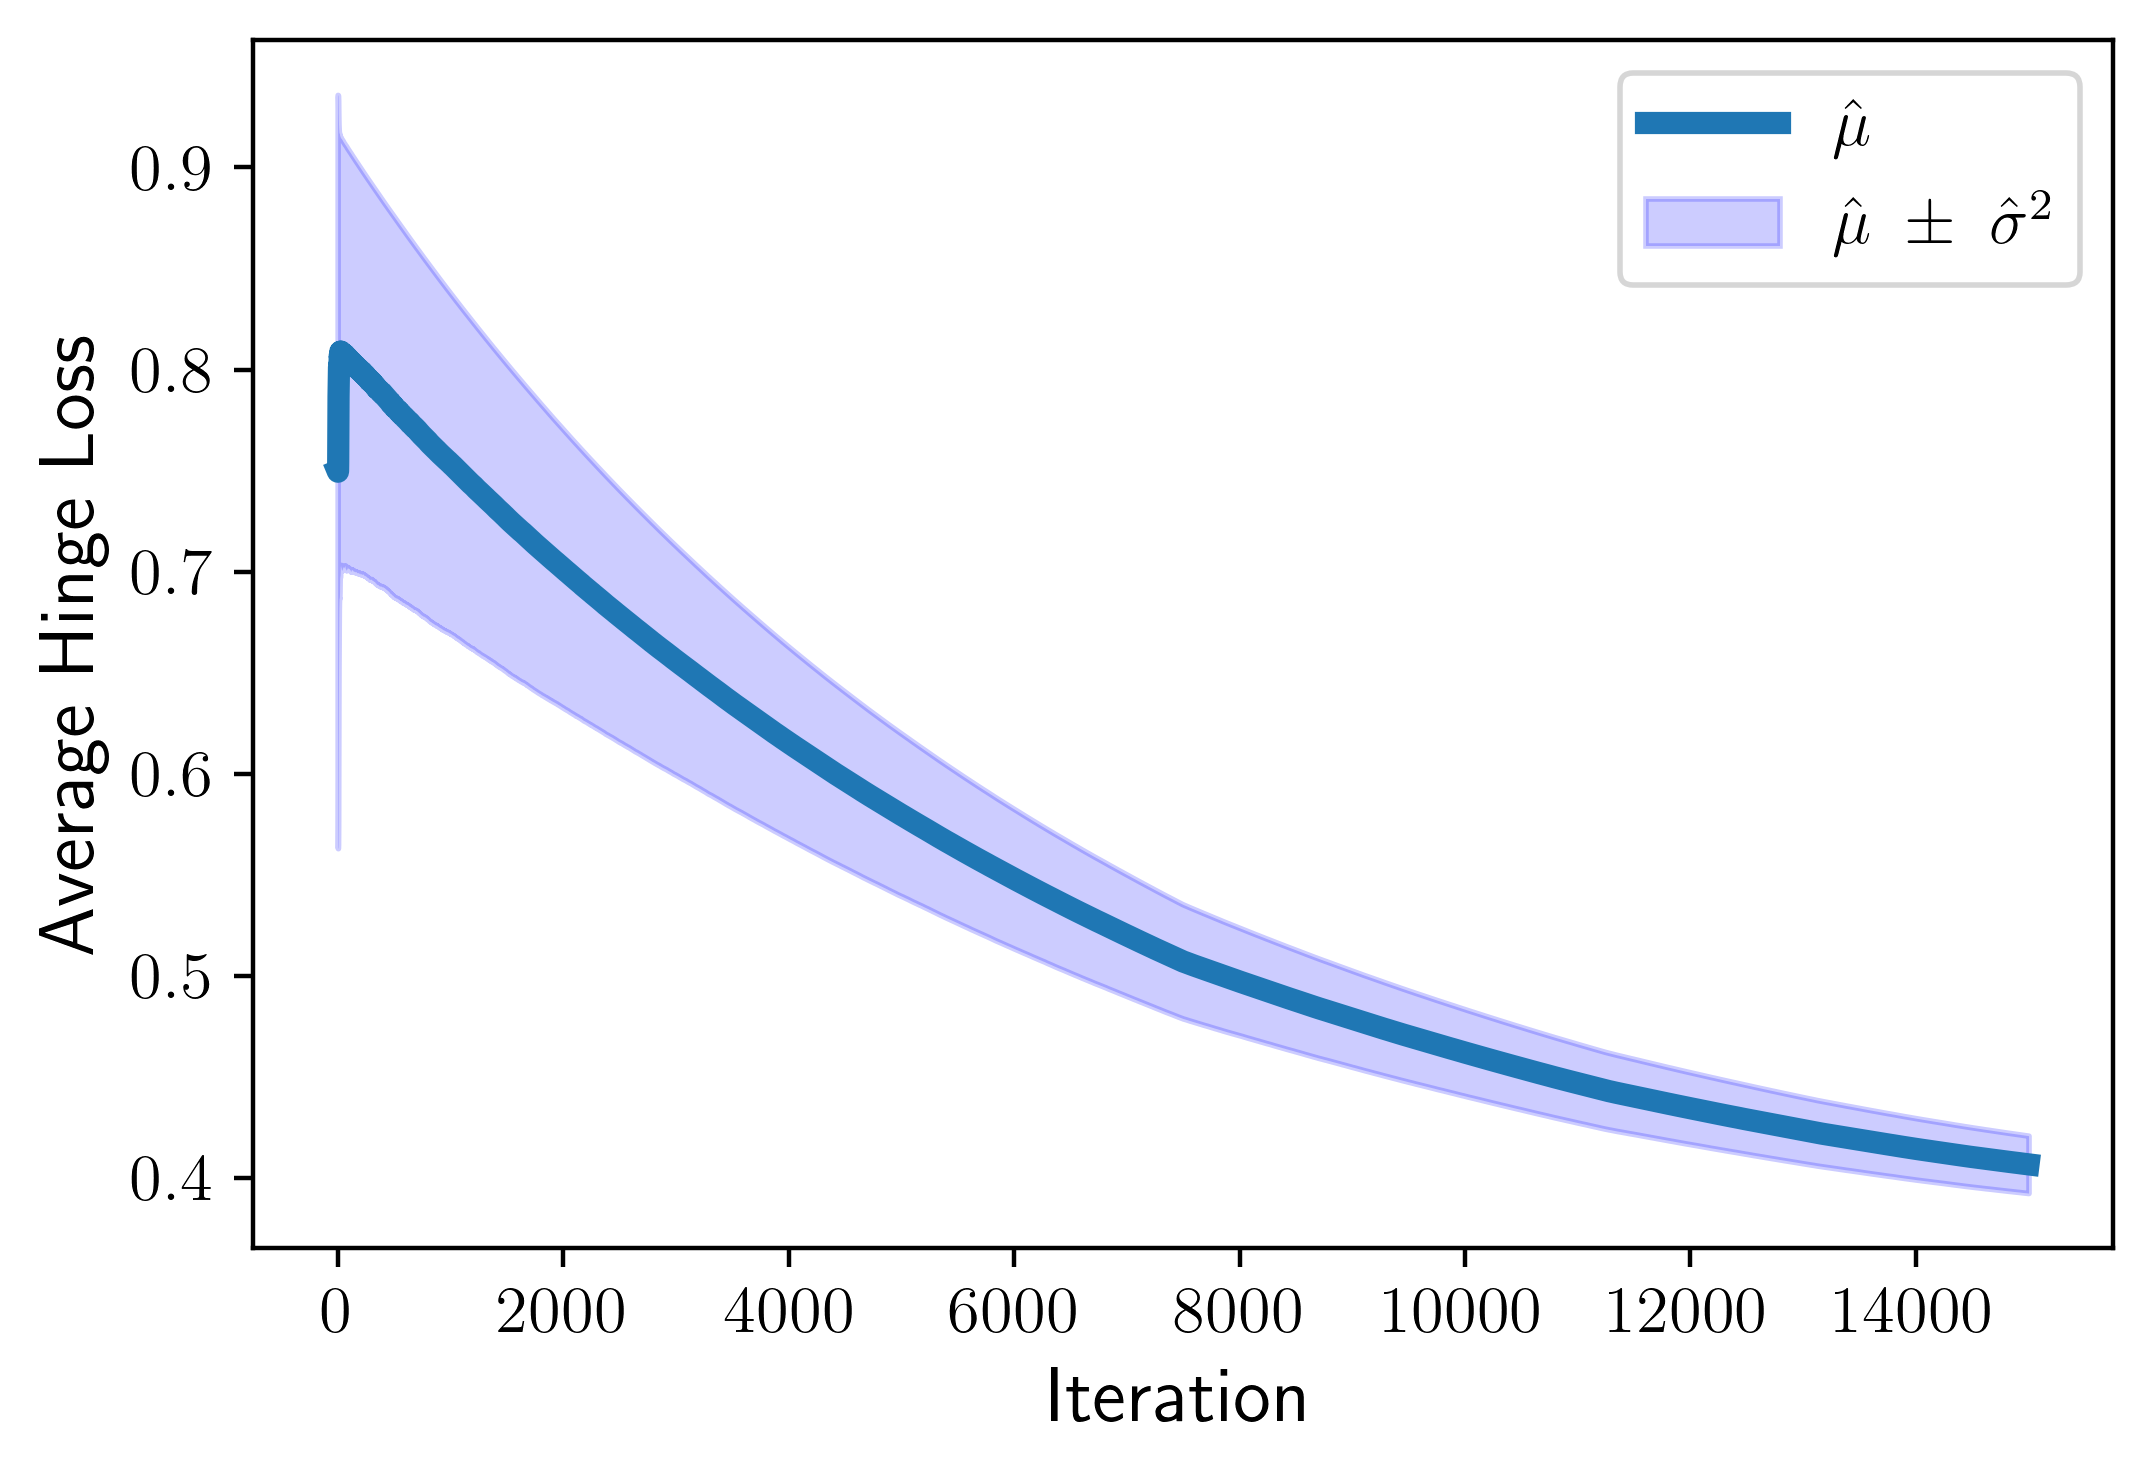

In [160]:
# couldn't get this function to work :(
runs = np.column_stack([constant_losses, constant_decay_losses, jain_losses, average_losses])     
def plot_variance(runs, label):
    runs_std = np.var(runs, axis=1)
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(runs)), np.mean(runs, axis=1), label=label)
    ax.fill_between(np.arange(len(runs)), (np.mean(runs, axis=1) - runs_std), (np.mean(runs, axis=1) + runs_std), color='b', alpha=0.2, label=r"$\hat{\mu}\;\pm\; \hat{\sigma}^2$")
    return ax

plot_variance(runs, r"$\hat{\mu}$")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Average Hinge Loss")
plt.show()

# Stochastic Utility 

Consider the stochastic utility problem 

$$\min\limits_{x\in\mathcal{X}}\left\{f(x) = \mathbb{E}\left[\phi\left(\sum\limits_{i=1}^n  \xi_ix_i\right)\right]\right\}$$

where $\mathcal{X}=\{x\in\mathbb{R}_+^n:\sum\limits_{i=1}^n x_i=1\}$, $\xi_i\sim$ Exp$(i)$ are independent, and $\phi(\cdot)$ is a piece-wise linear convex function given by $\phi(t)=\max\{s_1t, \dots , s_mt\}$ for a known constant sequence $\{s_k\}_{k=1}^m$ with $s_k\geq 0$. This setup allows the problem to be reduced easily as

$$
    \sum\limits_{i=1}^n \xi_i x_i\sim \text{Exp}\left(\sum\limits_{i=1}^n i x_i\right),\;\;\;\; \phi\left(\sum\limits_{i=1}^n \xi_i x_i\right)=\max\limits_{k\in[m]}\left\{s_k \sum\limits_{i=1}^n i x_i\right\}  
$$

where we can further deduce, denoting $\mathcal{P}[m]$ as the powerset of set of the first $m$ natural numbers excluding the empty set, that

$$
    \mathbb{E}\left[\max\limits_{k\in[m]}\left\{s_k \sum\limits_{i=1}^n \xi_i x_i\right\}\right] = \int\limits_0^\infty 1 - \prod\limits_{k=1}^m \left(1 - \exp\{-ys_k\sum\limits_{i=1}^n ix_i\}\right)dy  
$$

$$
    = \sum\limits_{\mathcal{K}\in\mathcal{P}[m]} (-1)^{|\mathcal{K}|-1}\int\limits_0^\infty \exp\{-y\sum\limits_{k\in\mathcal{K}} s_k\sum\limits_{i=1}^n ix_i\}dy = \sum\limits_{\mathcal{K}\in\mathcal{P}[m]} (-1)^{|\mathcal{K}| - 1} \left(\sum\limits_{k\in\mathcal{K}} s_k\sum\limits_{i=1}^n ix_i\right)^{-1}.
$$

This translates to an interesting problem that is dependent on our sequence $\{s_k\}_{k=1}^m$. For simplicity, consider $s_k=k$, then our objective is given by 

$$
    \min\limits_{x\in\mathcal{X}}f(x) = \min\limits_{x\in\mathcal{X}}\left\{\left(\sum\limits_{i=1}^n ix_i\right)^{-1}\sum\limits_{\mathcal{K}\in\mathcal{P}[m]} (-1)^{|\mathcal{K}| - 1} \left(\sum\limits_{k\in\mathcal{K}} k\right)^{-1}\right\}
$$

which is minimized with $x^*=e_n$ (the $n$th basis vector) as 

$$\sum\limits_{\mathcal{K}\in\mathcal{P}[m]} (-1)^{|\mathcal{K}| - 1} \left(\sum\limits_{k\in\mathcal{K}} k\right)^{-1}>0.
$$

I would like to employ stochastic gradient descent here and analyze suboptimality, so I consider obtaining estimates of the gradient by means of Monte Carlo where the partial with respect to $x_i$ is given by

$$
    \frac{\partial f(x)}{\partial x_i} = \int\limits_0^\infty 1-\frac{\partial}{\partial x_i}\prod\limits_{k=1}^m \left(1 - \exp\{-ys_k\sum\limits_{j\neq i} jx_j\}e^{-ys_kix_i}\right)dy
$$

$$
    =\int\limits_0^\infty 1 - \sum\limits_{k=1}^m\left[ys_ki\exp\{-ys_k\sum\limits_{i=1}^n ix_i\}\times\prod\limits_{j\neq i} \left(1 - \exp\{-ys_j\sum\limits_{i=1}^n ix_i\}\right) \right]dy.
$$

To perform Monte Carlo on this integral $I$, we must first transform the integral bounds for sampling (by partitioning the integral and then performing a change of variables on the one from $1$ to $\infty$), and we have:

$$
I = \int\limits_{0}^1 1 - \sum\limits_{k=1}^m\left[ys_ki\exp\{-ys_k\sum\limits_{i=1}^n ix_i\}\times\prod\limits_{j\neq k} \left(1 - \exp\{-ys_j\sum\limits_{i=1}^n ix_i\}\right) \right]dy + \int\limits_0^1 \frac{1}{z^2}\left(1 - \sum\limits_{k=1}^m\left[z^{-1}s_ki\exp\{-z^{-1}s_k\sum\limits_{i=1}^n ix_i\}\times\prod\limits_{j\neq k} \left(1 - \exp\{-z^{-1}s_j\sum\limits_{i=1}^n ix_i\}\right) \right]\right)dz.
$$
From here, we sample uniformly on $[0,1]$ to obtain sample estimates and run with the specified step sizes.

In this particular setting, I nearly forgot to project the solution on the simplex! The projection step after the update is given by 

$$\arg\min_{x\in\mathcal{X}} \left\{\frac{1}{2}\lVert\rVert_2^2\right\}$$

such that $1_n^Tx=1$ and $x_i\geq0$. We'll use CVXPY

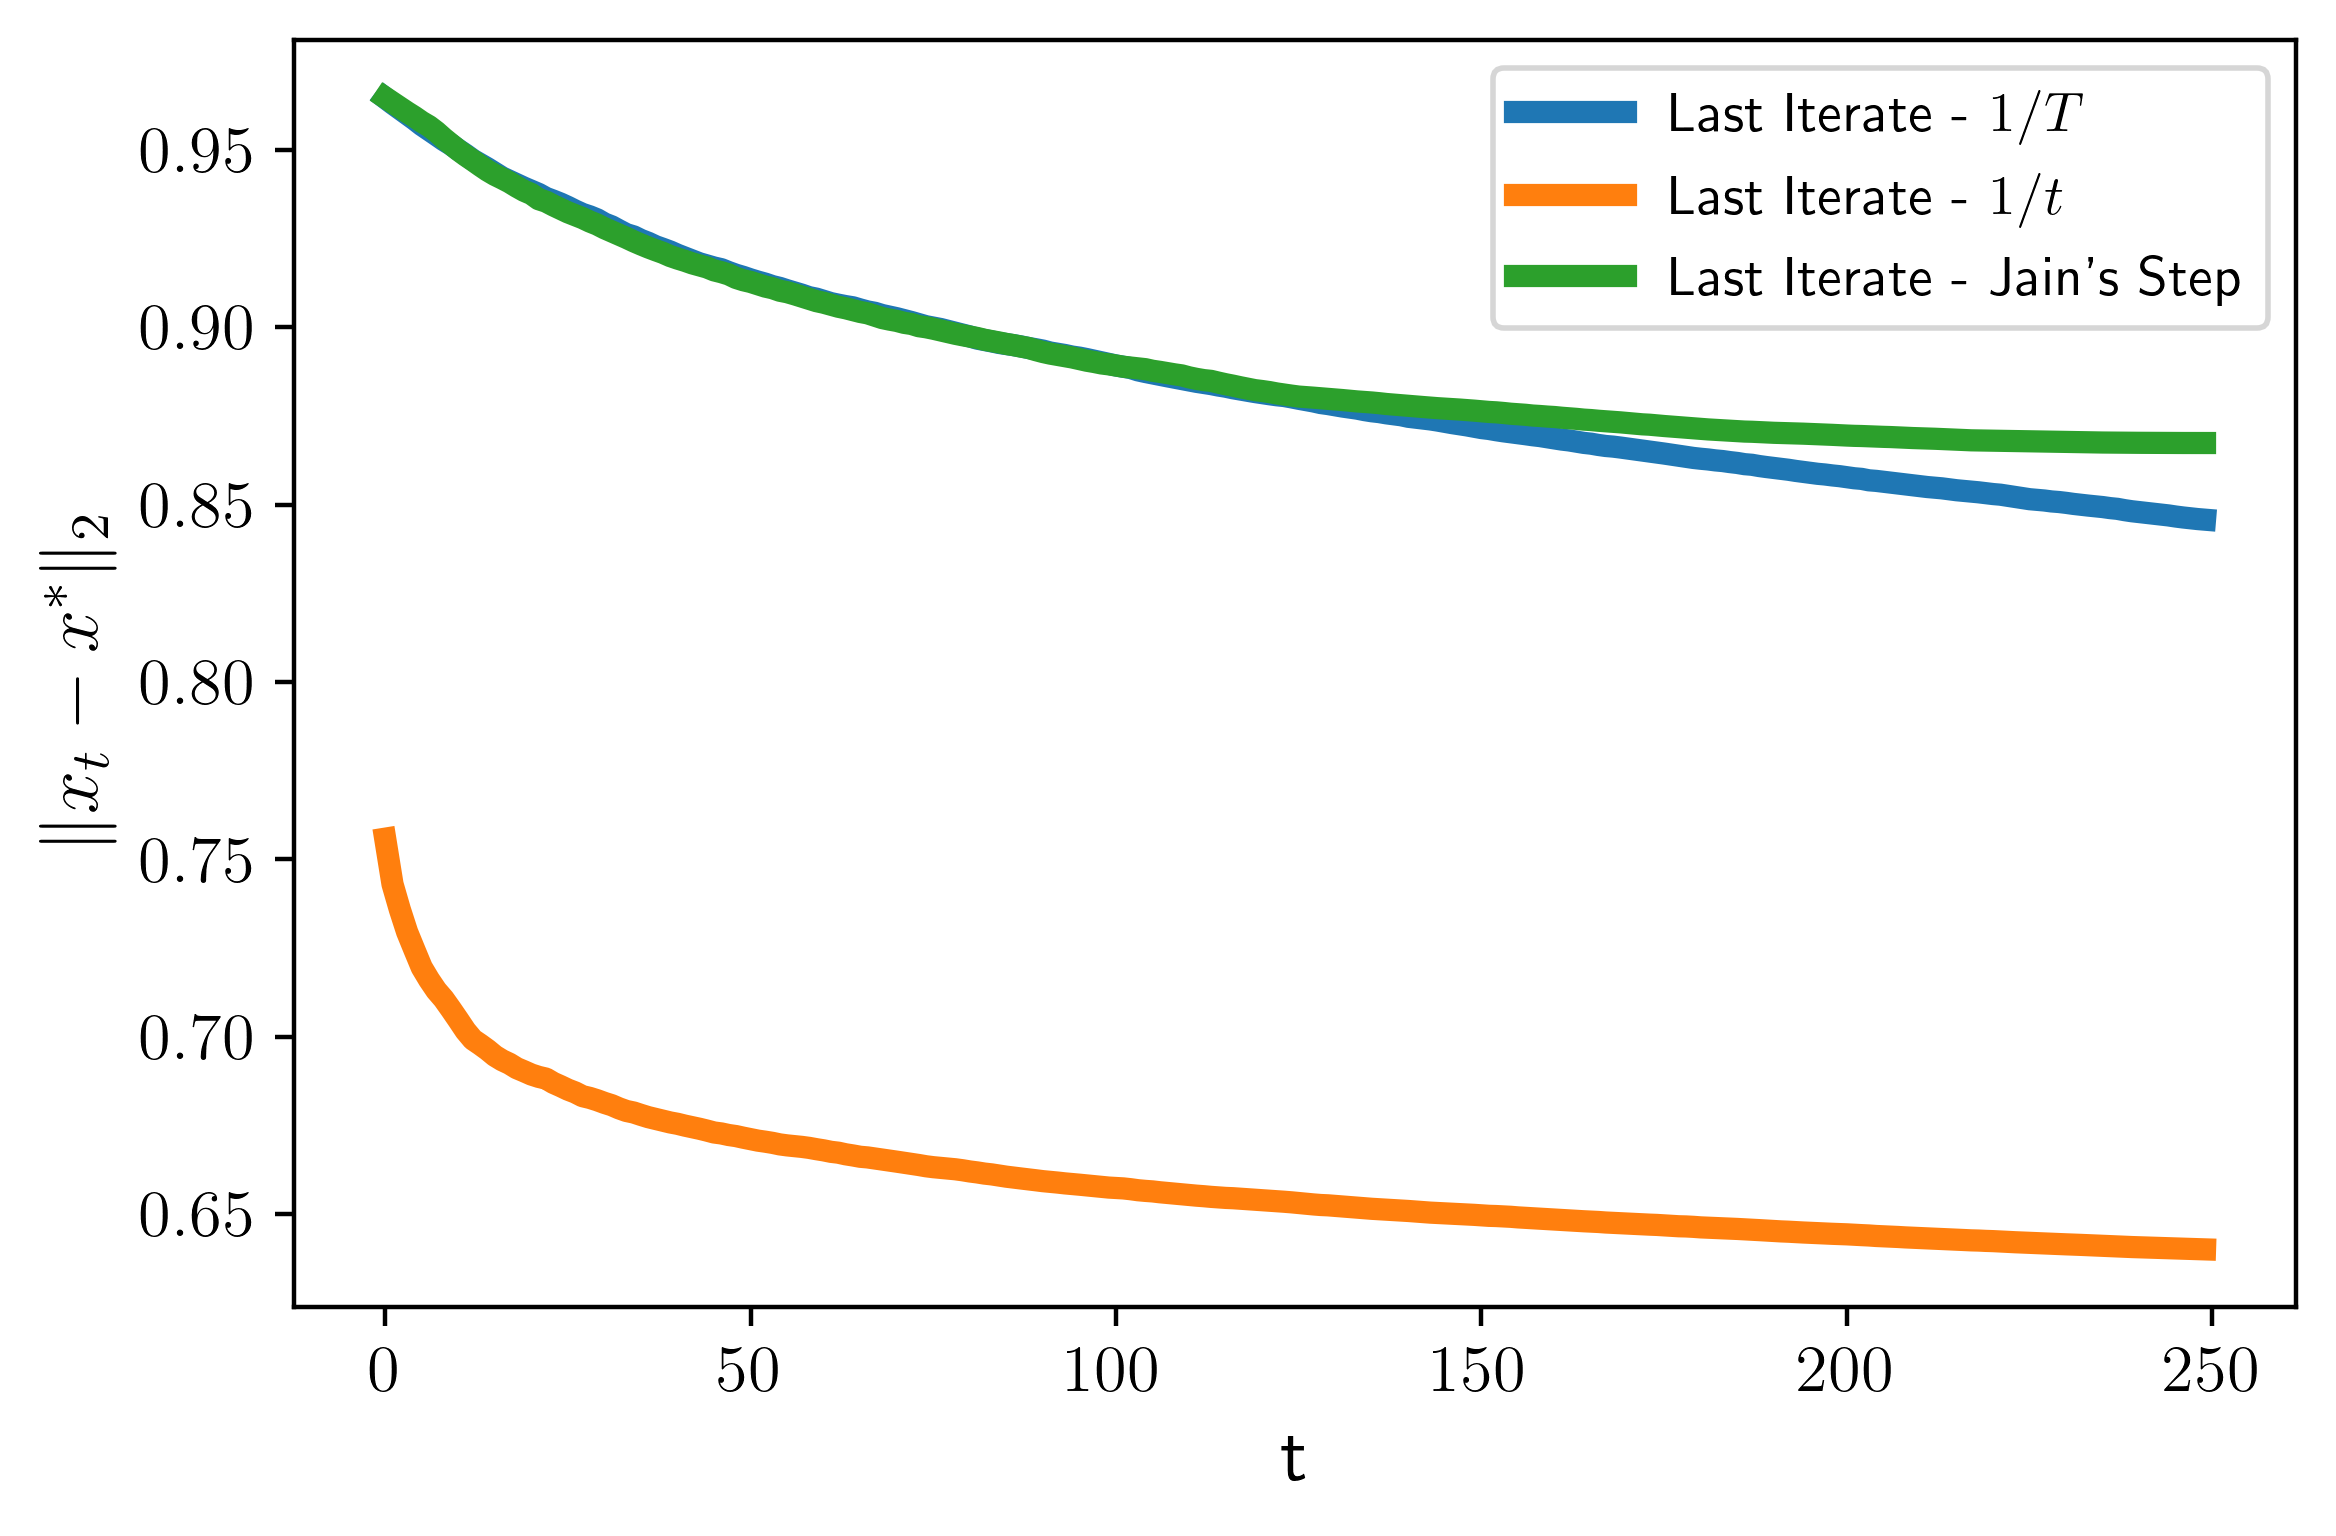

In [8]:
T = 250 # number of iterations
l = 50 # number of samples for monte carlo
m = 15 # dimension for the s sequence
n = 15 # dimension of x in the simplex
s = np.arange(1, m + 1)**(1/10)
x_0 = np.ones(n)*(1/n)
x_opt = np.zeros(n)
x_opt[n-1] = 1

def simplex_proj(y):
    # Returns the point in the simplex closest to y)
    dim = len(y)
 
    # setup the objective and constraints and solve the problem
    x = cvx.Variable(dim)
    obj = cvx.Minimize(cvx.sum_squares(x - y))
    constr = [cp.sum(x) == 1, x >= 0]
    prob = cvx.Problem(obj, constr)
    prob.solve()
 
    return np.array(x.value).squeeze()

def monte_carlo(obj, x, num_samples):
    # obj denotes a function to sample from
    # num_samples denotes the number of uniform samples drawn from [0,1]
    samples = np.random.uniform(0, 1, num_samples)
    f_values = [obj(y, x) for y in samples]
    return (1 / num_samples) * sum(f_values)

def integrand(y, x):
    partials = []
    ix = sum([i*x[i] for i in range(n)])
    for i in range(n):
        # compute integrand 1
        integrand_1 = 1
        for k in range(m):
            prod = 1
            for j in range(m):
                if j != k:
                    prod *= 1 - np.exp(-y*s[j]*ix)
                    
            integrand_1 -= y*s[k]*i*np.exp(-y*s[k]*ix)*prod
            
        # compute integrand 2
        integrand_2 = 1
        for k in range(m):
            prod = 1
            for j in range(m):
                if j != k:
                    prod *= 1 - np.exp(-y**(-1)*s[j]*ix)
                    
            integrand_2 -= y**(-1)*s[k]*i*np.exp(-y**(-1)*s[k]*ix)*prod
            
        partials.append(integrand_1 + integrand_2)
            
    return np.array(partials, dtype=object)
    
def grad_est(x):
    integral_est = monte_carlo(integrand, x, l)
    return np.array(integral_est, dtype=object)

def constant_step(t):
    return 1 / T

def constant_decay(t):
    return 1 / t

def sgd(T, step_size):
    # T is the number of iterations
    # step_size is a string argument
    # average is a boolean
    if step_size == "constant":
        steps = [constant_step(t) for t in range(T)]
    if step_size == "constant_decay":
        steps = [constant_decay(t) for t in range(1, T+1)]
    if step_size == "jain_step":
        T_set, alphas = jain_strong_stepsize(T, 1, 1)
        steps = alphas
    x_t = x_0
    x = []
    for t in range(T):
        g = grad_est(x_t)
        # project step on the simplex
        x_t = simplex_proj(x_t - steps[t]*g)
        x.append(x_t)
    return x

# fetch results
constant_subopt = [np.linalg.norm(x-x_opt, ord=2) for x in sgd(T, "constant")]
constant_decay_subopt = [np.linalg.norm(x-x_opt, ord=2) for x in sgd(T, "constant_decay")]
jain_subopt = [np.linalg.norm(x-x_opt, ord=2) for x in sgd(T, "jain_step")]

# visualize the results - same experiment as Jain
plt.plot(np.arange(T), constant_subopt, label=r"Last Iterate - $1/T$")
plt.plot(np.arange(T), constant_decay_subopt, label=r"Last Iterate - $1/t$")
plt.plot(np.arange(T), jain_subopt, label=r"Last Iterate - Jain's Step")
plt.xlabel(r"t")
plt.ylabel(r"$\lVert x_t - x^*\rVert_2$")
plt.legend(prop={'size': 10})
plt.tight_layout()
plt.show()

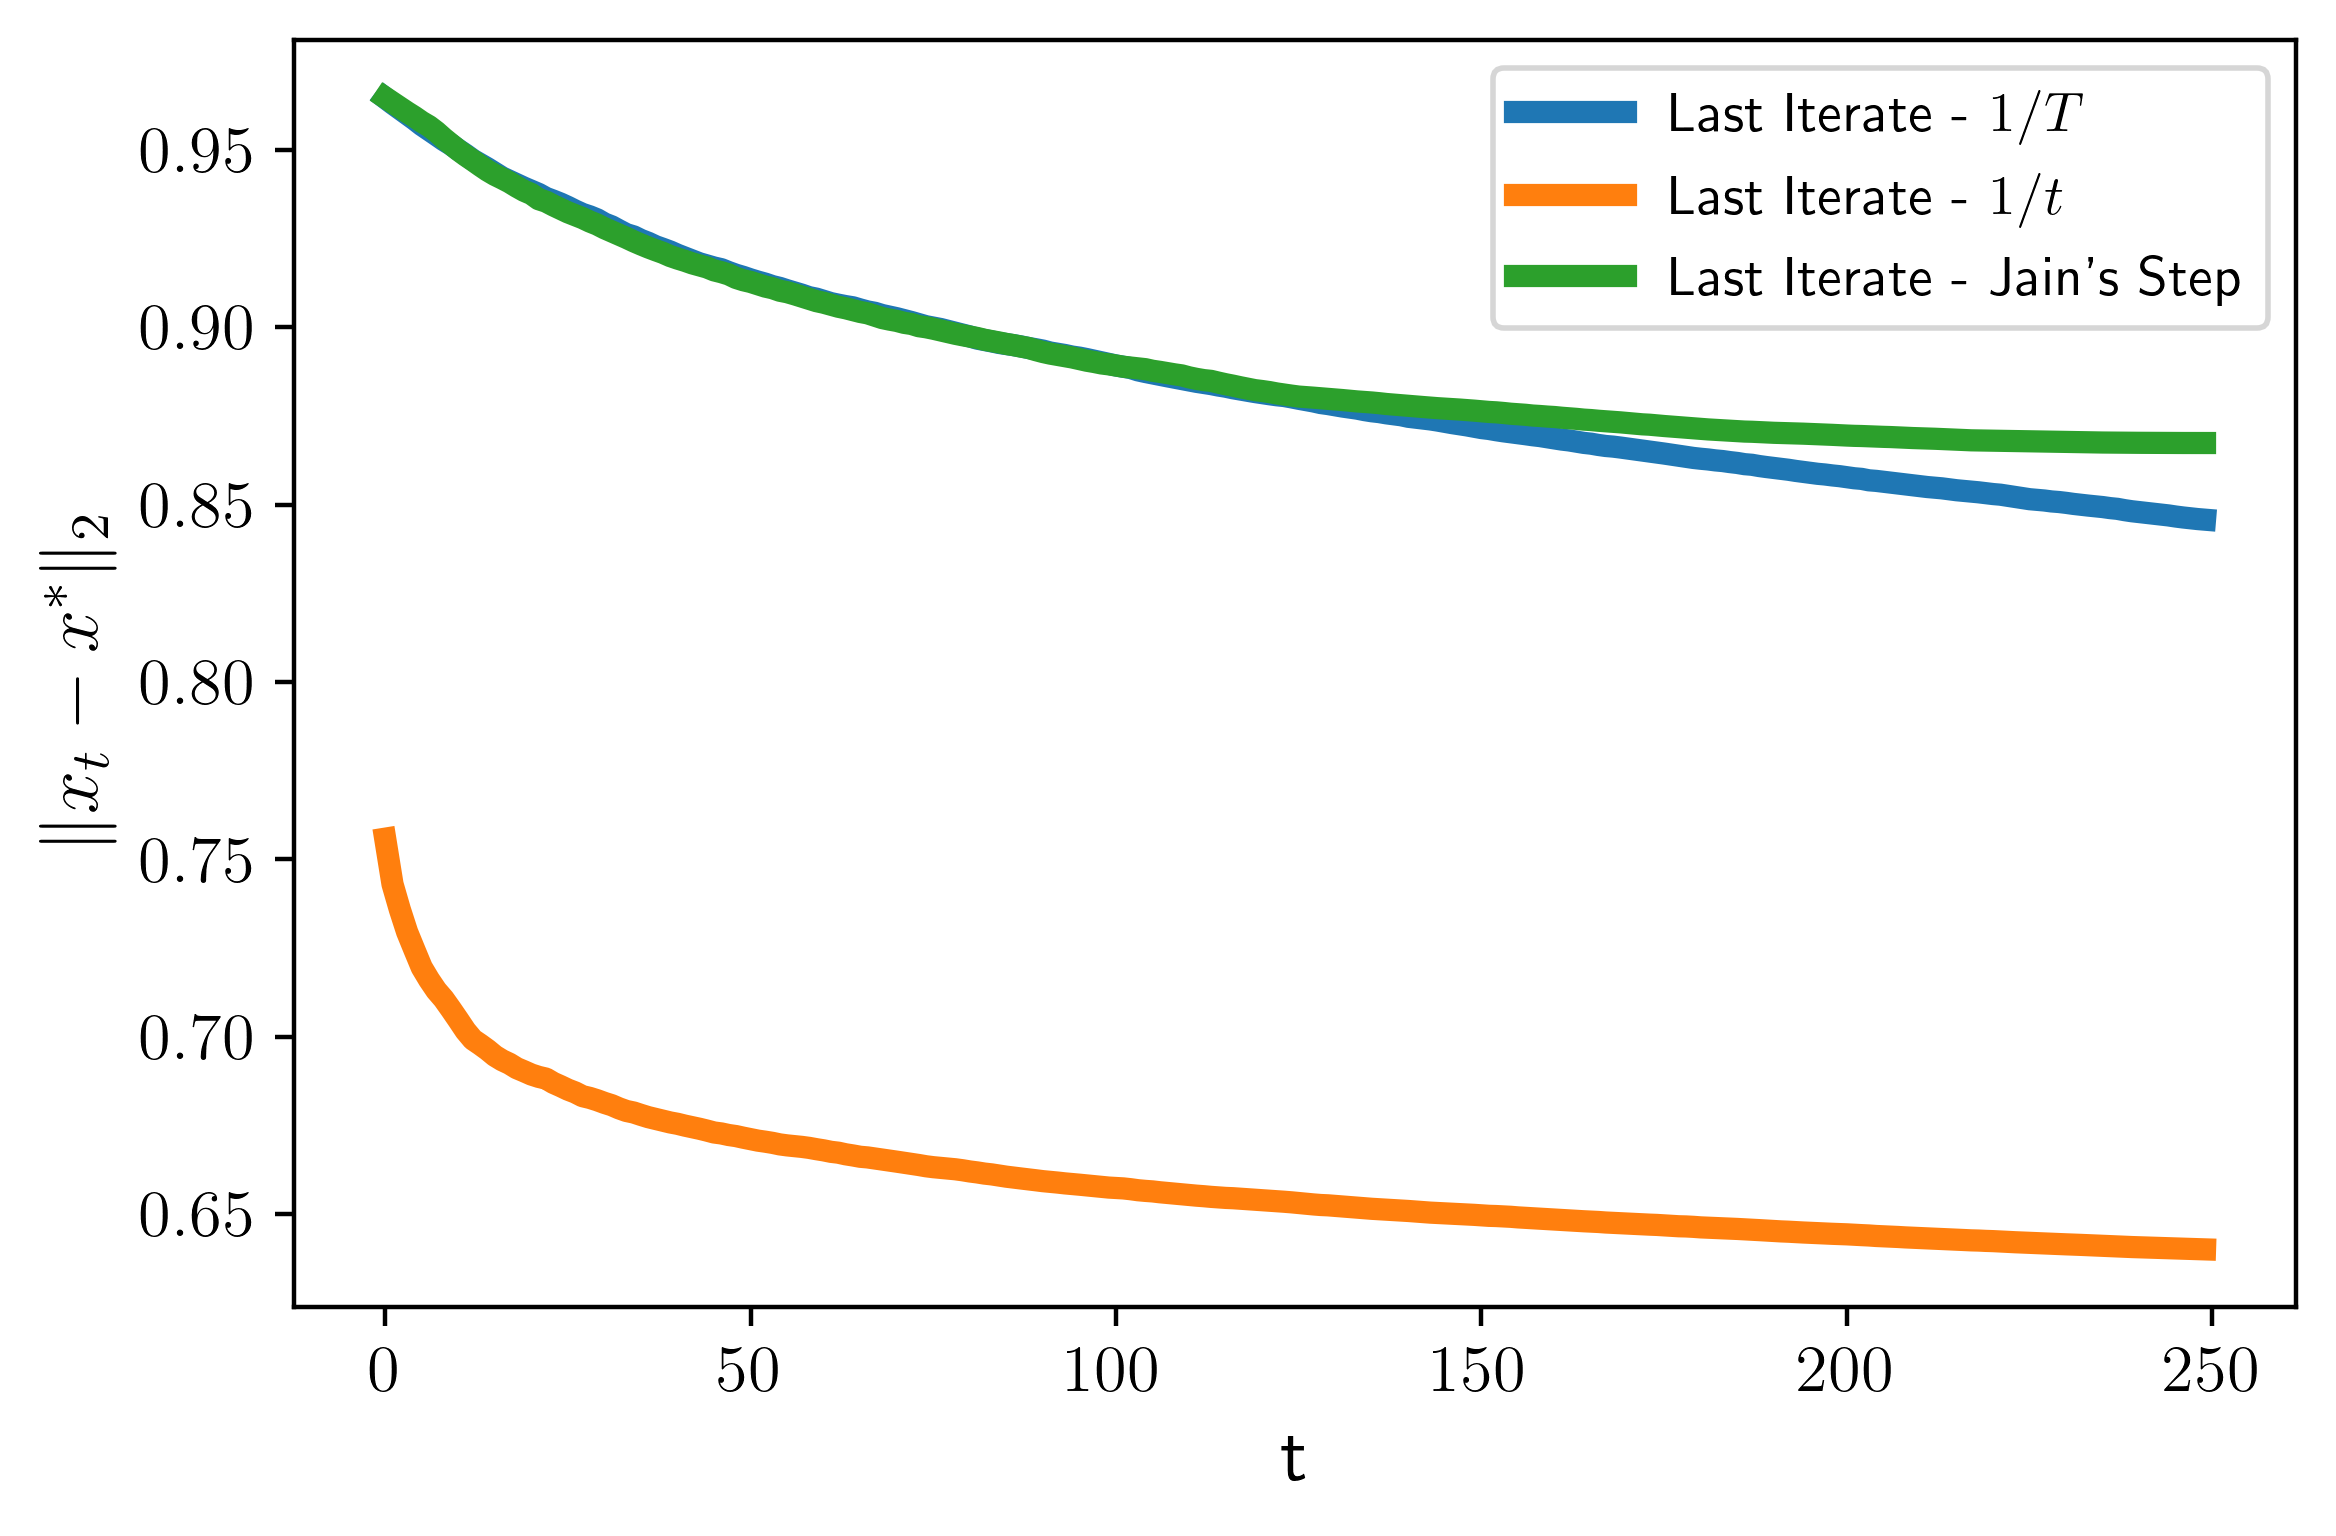

In [9]:
# visualize the results - same experiment as Jain
plt.plot(np.arange(T), constant_subopt, label=r"Last Iterate - $1/T$")
plt.plot(np.arange(T), constant_decay_subopt, label=r"Last Iterate - $1/t$")
plt.plot(np.arange(T), jain_subopt, label=r"Last Iterate - Jain's Step")
plt.xlabel(r"t")
plt.ylabel(r"$\lVert x_t - x^*\rVert_2$")
plt.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig('stochastic_utility.png', dpi=500)
plt.show()

In [ ]:
# looking at the series to see if it's positive
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]

P = powerset(np.arange(1, 9)**(1/10))
sum([(-1)**(len(x)-1)*float(sum(x))**(-1) for x in P])

## This setup was tried, but didn't work - problem is the parameter was negative :(
Consider the stochastic utility problem 

$$\min\limits_{x\in\mathcal{X}}\left\{f(x) = \mathbb{E}\left[\phi\left(\sum\limits_{i=1}^n  \xi_ix_i\right)\right]\right\}$$

where $\mathcal{X}=\{x\in\mathbb{R}_+^n:\sum\limits_{i=1}^n x_i=1\}$, $\xi_i\sim$ Exp$(i)$ are independent, and $\phi(\cdot)$ is a piece-wise linear convex function given by $\phi(t)=\max\{s_1t, \dots , s_mt\}$ for a known constant sequence $\{s_k\}_{k=1}^m$ with $s_k\leq 0$. This setup allows for simple, exact computation as 

$$\sum\limits_{i=1}^n \xi_i x_i\sim \text{Exp}\left(\sum\limits_{i=1}^n i x_i\right),\;\;\;\; \phi\left(\sum\limits_{i=1}^n \xi_i x_i\right)=\min\limits_{k\in[m]}\left\{-s_k \sum\limits_{i=1}^n i x_i\right\}  \sim \text{Exp}\left(-\sum\limits_{j=1}^m s_j\sum\limits_{i=1}^n i x_i\right)$$

further implying a trivial solution

$$\min\limits_{x\in\mathcal{X}}f(x) = \max\limits_{x\in\mathcal{X}}\left\{\sum\limits_{j=1}^m s_j\sum\limits_{i=1}^n i x_i\right\}=n\sum\limits_{j=1}^m s_j$$

with $x^*=e_n$ (the $n$th basis vector). However, this is not the goal of this review. Instead, we desire to estimate the gradient with Monte Carlo and perform SGD (which we can as the integrand is trivially continuously differentiable in $x$ and integrable for $x$ over the simplex)

$$\hat{g}_{x_i}=i\sum\limits_{j=1}^m s_j\int\limits_0^\infty y\exp\{-y\sum\limits_{j=1}^m s_j\sum\limits_{i=1}^m i x_i\}dy = i\sum\limits_{j=1}^m s_j\left[\int\limits_0^1 y\exp\{-y\sum\limits_{j=1}^m s_j\sum\limits_{i=1}^m i x_i\}dy + \int\limits_0^1 \frac{1}{y^3} \exp\{-y^{-1}\sum\limits_{j=1}^m s_j\sum\limits_{i=1}^m i x_i\}dy\right].$$

In our simple setup, let $n=500$ and $m=250$ with $s_k=-k$ for $k\in[m]$. For Monte-Carlo, I let $l=50$ initially.

# Bibliography

Main work - Jain et al, 2019: https://arxiv.org/pdf/1904.12443.pdf

Another main work - Harvey et al, 2019: https://www.cs.ubc.ca/~nickhar/papers/GradientDescent/GradientDescent.pdf

Seminal work on last iterate convergence: Shamir and Zhang, 2013: http://proceedings.mlr.press/v28/shamir13.pdf

Last Iterate Convergence under very specific instance: Liu and Lu, 2021: https://arxiv.org/pdf/2106.14588.pdf

ADAM doesn't generalize like SGD - this paper is important in that it highlights the need for PROBABILITY BOUNDS of LARGE DEVIATIONS NOT EXPECTATION BOUNDS: https://proceedings.neurips.cc/paper/2020/file/f3f27a324736617f20abbf2ffd806f6d-Paper.pdf

LASSO shouldn't use SGD - many more options: https://people.duke.edu/~hpgavin/SystemID/References/Schmidt-UBC-TR-2009-19.pdf

Okay source on SVM formulations: http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/stfhtmlnode64.html


NEMIROVSKY IS A GOAT - everything he says is mathematically rigorous, no hand wave, but still crystal clear unlike Nesterov. I now trust his research - here are two examples with respect to stochastic approximation that I found amazing:

- https://www2.isye.gatech.edu/~nemirovs/SIOPT_RSA_2009.pdf

- https://arxiv.org/pdf/1907.02707.pdf

Probability (unrelated to notebook, but just found this gem): https://web.math.princeton.edu/~nelson/books/rept.pdf

Brownian motion (unrelated, but again - this dude creates gems): https://web.math.princeton.edu/~nelson/books/bmotion.pdf

SGD formulation: https://perso.math.univ-toulouse.fr/gadat/files/2012/12/cours_Algo_Stos_M2R5.pdf